# Machine Learning I / Lab 3 Clustering
## Authors:</b> Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
### Data set from:</b> https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

### Overview
The team started with doing EDA to understand the data and what will make sense to form clustering. Team followed two approaches using multiple clustering methods to validate the formation of the cluster.

In the first approach, the best possible number of clusters was determined using the elbow method and run the grid search to establish optimal parameters for different clustering techniques.   To further understand our clusters, we used a logistical regression model with the cluster as a target to show how the cluster was formed.

In the second approach, accuracy was the prime focus to establish the number of clusters leveraging different regression techniques. Our goal here was to increase the accuracy of known regression and random forest models by replacing variables with a cluster that was created from the replaced variables.

The team also worked on formatting personas leveraging excel tools and analyzing the content of each cluster created by Kmean.


# Business Understanding

## Purpose of Data

The data for our analysis is related to Cardiac Heart Disease.  It was collected from 70,000 patients. It has 12 attributes which include an indicator to describe if a patient has Cardiac Heart Disease (CHD). The data we picked does not specify in its source about why the data was collected. However, it contains information about factors that can be lead indicators for CHD. These factors include hypertention, smoking, alcohol, gender, cholesterol, glucose levels, age, activity, weight and height. Based on the contents of this data, we can assume it was collected to determine key contributors to CHD.

According to the American Heart Association, approximately 43% of adults in the of the United States have CHD events.  Of that population, it is fatal for 55% of men and 51% of women. In those with established CHD 30% had more than 1 recurrent event. Therefore, data to determine who may be prone to CHD can be a valuable tool for the medical community and early detection can lead to life saving treatment.

## Validation Methods for Clustering Algorithms

### Calinski Harabasz Score

We used the Calinski Harabasz score to compare multiple clustering algorithms with multiple options and pick the model that best suited our goals. This metric is used to pick the optimal number of clusters and is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.  It is higher when the clusters are more dense and more distant from other clusters. We picked this metric because it does not need external labels and is fast to compute.

We have a large dataset.   Initially, we tried to use Silhouette Scores.  However, when comparing many algorithms and many parameters for each algorithm, it became computationally expensive.   Therefore, we looked for a metric that would be more efficient to run on our larger dataset.

Our stakeholders will be healthcare providers.   They need something simple and quick to understand and we are able to generate this quickly and explain the results.  This validation algorithm is easy to explain and understand since the higher score indicates a better result.  Other algorithms, such as silhouette score, have more complicated outcomes such as negative scores and do not mesure the density of the cluster as well as the separation.

### Internal and External Validation

We use both internal and external validation in our analysis of clusters. For internal validation, we selected the Calinski-Harabasz score as an internal measurement of clustering and grid searched for a model with the highest score. For external validation, we used the clusters to make a predictive model for cardiac disease, and chose the clustering model which produced the highest accuracy.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain

from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import jaccard_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
#load in data
df = pd.read_csv("cardio_train.csv", sep=";")

# Data Understanding

There are 3 types of attributes:

* Objective: factual information
* Examination: results of medical examination
* Subjective: information given by the patient


**age** (Objective):    The age of the patient in days.  Values range from 10798 days (29 years) to 23713 days (about 65 years)

**height** (Objective):   The height of the patient in centimeters

**weight** (Objective):  The weight of the patient in Kilograms

**gender** (Objective):  Categorical code of 1 for woman or 2 for man

**ap_hi** (Examination):  Systolic Blood Pressure   *Integer* 

**ap_lo** (Examination):  Diastolic blood pressure   *Integer*

**cholesterol** (Examination): 1: normal, 2: above normal, 3: well above normal

**gluc**  (Examination):  Glucose  1: normal, 2: above normal, 3: well above normal

**smoke** (Subjective)   Indicator to determine whether patient smokes or not  (binary)

**alco** (Subjective): Indicator to determine if patient drinks alcohol or not (binary)

**active** (Subjective): Indicator to determine if patient is active or not (binary)

**cardio** (Examination):  Target variable to determine if heart disease is present (binary)

<b>The following are variables created within the EDA process:</b>
<br>
<br><b>age_yr</b>: Age in years.   Age (in days) / 360
<br><b>new cholesterol column</b>:  Normal (cholesterol = 1) or High (cholesterol = 2 or 3)
<br><b>new glucose column</b>:  Normal (gluc=1) or High (gluc = 2 or 3) 
<br><b>BMI</b>: Body Mass Index calculated as folows: <b> weight (in kg) / (height(in cm)/100)^2 </b>
<br>
<br><b>bmiGrp</b>: Grouping body mass index into 4 categorical groups:
<br><b>Values</b>
<br><b> 1</b>: Underweight: BMI < 18.5)
<br><b> 2</b>: Normal: BMI between 18.5 and 25
<br><b> 3</b>: Over Weight: BMI between 25 and 30
<br><b> 4</b>: Obese:  BMI  > 30
<br>
<br><b>bp</b>: Grouping blood pressure into 4 categorical groups:
<br><b> Values</b>
<br><b> 1</b>: Normal:  Systolic Blood Pressure Less than 120 and Diastolic blood pressure Less than 80
<br><b> 2</b>: Elevated:  Systolic Blood Pressure between 120 and 130 and Diastolic blood pressure Less than 80
<br><b> 3</b>: Hyper_Stage_1: Systolic Blood Pressure between 130 and 140 and Diastolic blood pressure between 80 and 90
<br><b> 4</b>: Hyper_Stage_2:  Systolic Blood Pressure greater or equal to 140 and Diastolic greater than or equal to 90
<br><b> 5</b>: Hyper_Stage_3: Systolic Blood Pressure greater than 180 and Diastolic blood pressure greater than 120



##  Verify Data Quality

### Analysis of Data Outliers and Invalid Data 

Our data outlier analysis is below.   We found that we had values in some continuous variable that should be considered errors rather than outliers.  In these cases, we omitted the bad data.  Some examples are blood pressure values of over 1000 or less than 1.   It is not possible for a human to have these values for blood pressure.  Similarly, there were values in height and weight that could not be considered valid data for a living person.    In these cases, it was not possible for us to come up with a reasonable value, so we omitted the rows from the original data.   This led to a reduction of around 17,000 rows out of 70,000 (or 24%).  

In [2]:
dfhw= df[["height", "weight","ap_hi", "ap_lo"]]
dfhw.describe()

height        weight         ap_hi         ap_lo
count  70000.000000  70000.000000  70000.000000  70000.000000
mean     164.359229     74.205690    128.817286     96.630414
std        8.210126     14.395757    154.011419    188.472530
min       55.000000     10.000000   -150.000000    -70.000000
25%      159.000000     65.000000    120.000000     80.000000
50%      165.000000     72.000000    120.000000     80.000000
75%      170.000000     82.000000    140.000000     90.000000
max      250.000000    200.000000  16020.000000  11000.000000

#### Height and Weight

Height and weight show some unreasonable values. An adult should not be >200 kg or <55 kg so we will assume those are mistakes and remove these data. An adult should also not be >200 cm or <130 cm so we will assume those are mistakes and remove these data.

Text(0.5, 1.0, 'Boxplot of Height and Weight')

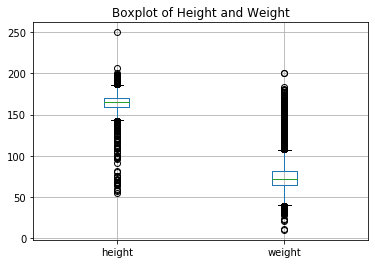

In [3]:
#Box plot of height and weight
dfs= df[["height", "weight"]]
ax = dfs.boxplot()
ax.set_title('Boxplot of Height and Weight')

#### Blood Pressure

Boxplots show that ap_hi (systolic blood pressure) and ap_lo (diastolic blood pressure) have some major outliers skewing the data. We can also see that these outliers are not reasonable values, based on domain knowledge by Dr. Fabio Savorgnan. It is unreasonable for systolic blood pressure to be >200 or <110, and it is unreasonable for diastolic blood pressure to be >150 or <60 so we remove them.

Text(0.5, 1.0, 'Boxplot of Blood Pressure')

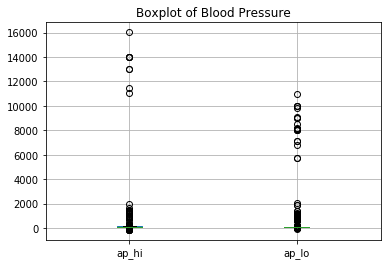

In [4]:
#Box plot of ap_hi (systolic blood pressure) and ap_low (diastolic blood pressure)
dfs= df[["ap_hi", "ap_lo"]]
ax = dfs.boxplot()
ax.set_title('Boxplot of Blood Pressure')

# Data Processing

Clean up data so that we are removing invalid observations.

In [5]:
# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

# Drop ID
df = df.drop('id', axis=1)

## Visualize Attributes

Our most important attributes are blood pressure, BMI, cholesterol, glucose, and age. These features each are able to capture differences between those with and without heart disease.

### Blood Pressure

In the normal blood pressure level group, only 22% have heart attack. However, in the hypertension stage 2 group, the proportion goes up to 80% having heart attack. In hypertension stage 3, 82% have heart attack. It is clear that those with higher levels of blood pressure have increased likelihood of heart disease.This finding is similar to the evidence base medicine literature.

In [6]:
# bin blood pressure groups based on the api hi/ lo variables
df_viz = df
df_viz['bp'] = np.where((df_viz.ap_hi < 120) & (df_viz.ap_lo < 80), 1, 0)
df_viz['bp'] = np.where((df_viz.ap_hi >= 120) & (df_viz.ap_hi < 130) & (df_viz.ap_lo < 80), 2, df_viz.bp)
df_viz['bp'] = np.where((df_viz.ap_hi >= 130) & (df_viz.ap_hi < 140) | ((df_viz.ap_lo >= 80) & (df_viz.ap_lo < 90)), 3, df_viz.bp)
df_viz['bp'] = np.where((df_viz.ap_hi >= 140) | (df_viz.ap_lo >= 90), 4, df_viz.bp)
df_viz['bp'] = np.where((df_viz.ap_hi > 180) | (df_viz.ap_lo > 120), 5, df_viz.bp)
df_viz['bp1'] = pd.cut(df_viz.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Text(0.5, 1.0, 'Cardiac Event and Blood Pressure')

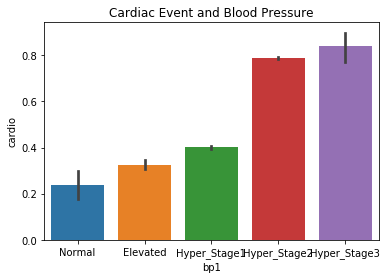

In [7]:
#bar plot blood pressure levels percent having cardiac disease 
sns.barplot(x='bp1', y='cardio', data=df_viz, saturation=0.8)
plt.title('Cardiac Event and Blood Pressure')

### BMI

We created a Body Mass Index (BMI) variable because domain knowledge tells us that high levels of obesity are related to increased chance of heart disease.

Body Mass Index (BMI) is calculated as: <b> weight (in kg) / (height(in cm)/100)^2 </b>. We bucketed people into the following categories:

* Under Weight: BMI < 18.5
* Normal Weight: 18.5 <= BMI < 25
* Over Weight: 25 <= BMI < 30
* Obese: BMI >= 30

In [8]:
# compute the body mass index based on weight and height
df_viz['bmi'] = df_viz['weight'] / (df_viz['height']/100)**2

# create BMI group categorical bins
df_viz['bmiGrp'] = np.where((df_viz.bmi < 18.5), 1, 0)
df_viz['bmiGrp'] = np.where((df_viz.bmi >= 18.5) & (df_viz.bmi < 25), 2, df_viz.bmiGrp)
df_viz['bmiGrp'] = np.where((df_viz.bmi >= 25) & (df_viz.bmi < 30), 3, df_viz.bmiGrp)
df_viz['bmiGrp'] = np.where((df_viz.bmi >= 30), 4, df_viz.bmiGrp)
df_viz['bmiGrp1'] = pd.cut(df_viz.bmiGrp,[0,1,2,3,4],4,labels=['Under Weight','Normal Weight','Over Weight','Obese' ]) # this creates a new variable


Most of our observations are among people who are normal weight, overweight, or obese. See the counts below.

In [9]:
#show counts of people in each BMI group
df_grouped = df_viz.groupby(by='bmiGrp1')
df_grouped[['bmiGrp']].count()

bmiGrp
bmiGrp1              
Under Weight       37
Normal Weight   17137
Over Weight     20206
Obese           15673

### BMI

We created a Body Mass Index (BMI) variable because domain knowledge tells us that high levels of obesity are related to increased chance of heart disease.

Body Mass Index (BMI) is calculated as: <b> weight (in kg) / (height(in cm)/100)^2 </b>. We bucketed people into the following categories:

* Under Weight: BMI < 18.5
* Normal Weight: 18.5 <= BMI < 25
* Over Weight: 25 <= BMI < 30
* Obese: BMI >= 30


In [10]:

# compute the body mass index based on weight and height
df_viz['bmi'] = df_viz['weight'] / (df_viz['height']/100)**2

# create BMI group categorical bins
df_viz['bmiGrp'] = np.where((df_viz.bmi < 18.5), 1, 0)
df_viz['bmiGrp'] = np.where((df_viz.bmi >= 18.5) & (df_viz.bmi < 25), 2, df_viz.bmiGrp)
df_viz['bmiGrp'] = np.where((df_viz.bmi >= 25) & (df_viz.bmi < 30), 3, df_viz.bmiGrp)
df_viz['bmiGrp'] = np.where((df_viz.bmi >= 30), 4, df_viz.bmiGrp)
df_viz['bmiGrp1'] = pd.cut(df_viz.bmiGrp,[0,1,2,3,4],4,labels=['Under Weight','Normal Weight','Over Weight','Obese' ]) # this creates a new variable


#Most of our observations are among people who are normal weight, overweight, or obese. See the counts below.

#show counts of people in each BMI group
df_viz_grouped = df_viz.groupby(by='bmiGrp1')
df_viz_grouped[['bmiGrp']].count()

bmiGrp
bmiGrp1              
Under Weight       37
Normal Weight   17137
Over Weight     20206
Obese           15673

Comparing our BMI groups by their proportions having heart disease, we can see that BMI is a useful indicator for heart disease. The obese group has 65% of its people with heart disease. In comparison, the underweight group has only 42% with heart disease.This finding is also similar to the evidence base medicine literature.

Text(0.5, 1.0, 'Cardiac Event and BMI')

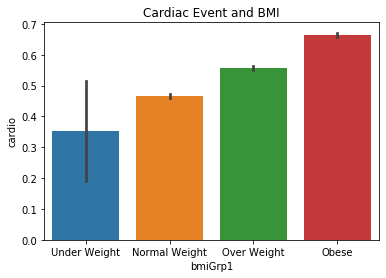

In [11]:
sns.barplot(x='bmiGrp1', y='cardio', data=df_viz, saturation=0.8)
plt.title('Cardiac Event and BMI')

### Cholesterol

Cholesterol values over 1 seem to have an impact on cardiovascular disease.

Text(0.5, 0, 'Cholesterol (1=Normal, 2=Above Normal, 3=Well Above Normal)')

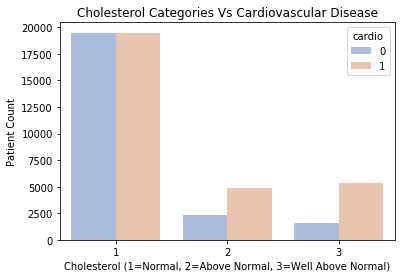

In [12]:
bc=sns.countplot(x="cholesterol", hue="cardio",  alpha=.5, palette="muted",data=df)
bc.set_title('Cholesterol Categories Vs Cardiovascular Disease')
bc.set_ylabel('Patient Count')
bc.set_xlabel('Cholesterol (1=Normal, 2=Above Normal, 3=Well Above Normal)')

### Glucose

Glucose above normal categories seem to be more common among those with cardiovascular disease than those without.

Text(0.5, 0, 'Glucose (1=Normal, 2=Above Normal, 3=Well Above Normal)')

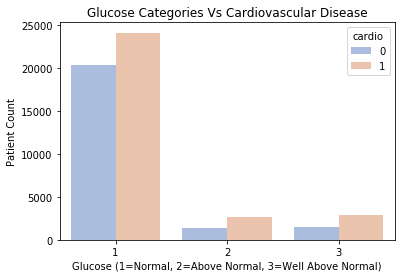

In [13]:
bc=sns.countplot(x="gluc", hue="cardio",  alpha=.5, palette="muted",data=df)
bc.set_title('Glucose Categories Vs Cardiovascular Disease')
bc.set_ylabel('Patient Count')
bc.set_xlabel('Glucose (1=Normal, 2=Above Normal, 3=Well Above Normal)')

### Age

The age distribution of those with cardiac disease is older than the noncardio population.

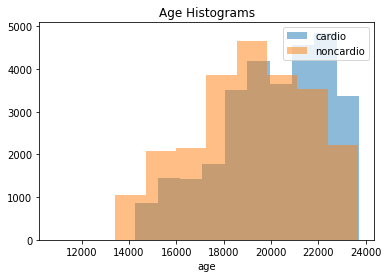

In [14]:
cardio = df[df["cardio"]==1]
noncardio = df[df["cardio"]==0]


plt.hist(cardio['age'], alpha=0.5, label='cardio')
plt.hist(noncardio['age'], alpha=0.5, label='noncardio')
plt.title("Age Histograms")
plt.xlabel("age")
plt.legend(loc='upper right')
plt.show()

# Final dataframe

In [15]:
df
df1 = df[["age","cholesterol", "gluc", "smoke", "alco", "ap_hi", "ap_lo", "bmi", "cardio"]]
df1.head()

age  cholesterol  gluc  smoke  alco  ap_hi  ap_lo        bmi  cardio
1  20228            3     1      0     0    140     90  34.927679       1
2  18857            3     1      0     0    130     70  23.507805       1
3  17623            1     1      0     0    150    100  28.710479       1
5  21914            2     2      0     0    120     80  29.384676       0
6  22113            3     1      0     0    130     80  37.729725       0

# Data Analysis using Clustering

## Description of Clustering Methods Used

### Kmean 

https://prosancons.com/education/pros-and-cons-of-k-means-clustering/

<b>Pros:</b> 

Simple: It is easy to implement k-means and identify unknown groups of data from complex data sets. The results are presented in an easy and straightforward manner.

Suitable in a large dataset: K-means is suitable for large datasets, where it computes much faster than other algorithms. 


Efficient: The Kmean algorithm is good at segmenting the large data set. Its efficiency depends on the shape of the clusters. K-means works well in hyper-spherical clusters.


Time complexity: K-means segmentation is linear in the number of data objects, thus increasing execution time. It does not take more time to classify similar characteristics in data like hierarchical algorithms.


Tight clusters: Compared to hierarchical algorithms, k-means produce tighter clusters, especially with globular clusters.


Easy to interpret: The results are easy to interpret. It generates cluster descriptions in a form minimized to ease understanding of the data.


Computation cost: Compared to other clustering methods, a k-means clustering technique is fast and efficient in terms of its computational cost

Accuracy: K-means analysis improves clustering accuracy and ensures information about a particular problem domain is available. Modification of the k-means algorithm based on this information improves the accuracy of the clusters.

Spherical clusters: This mode of clustering works excellent when dealing with spherical clusters. It operates with an assumption of joint distributions of features since each cluster is spherical. All the clusters features or characters have equal variance, and each is independent of the other.


<b>Cons:</b>


No-optimal set of clusters: K-means do not allow the development of an optimal set of the cluster. Calculate the optimal cluster using the elbow method for significant results.

Lacks consistency: K-means clustering may give varying results on different runs of an algorithm. A random choice of cluster patterns yields different clustering results resulting in inconsistency.


Uniform effect: It produces a cluster with a uniform size even when the input data has different sizes.

Order of values: The order of data in building the algorithm affects the final results of the data set.

Sensitivity to scale: Changing or rescaling the dataset either through normalization or standardization will completely change the final results.

Handle numerical data: K-means algorithm can be performed in numerical data only.

Operates in assumption: K-means clustering technique assumes that we deal with spherical clusters, and each cluster has equal numbers for observations. The spherical assumptions have to be satisfied. The algorithm cannot work with clusters of unusual size.


### Hierarchical clustering algorithm
<b>Pros:</b>

No priori information about the number of clusters required.

Easy to implement and gives the best result in some cases.

<b>Cons: </b>

An algorithm can never undo what was done previously.

The time complexity of at least (n2 log n) is required, where ‘n’ is the number of data points.

Based on the type of distance matrix chosen for merging, different algorithms can suffer from one or more of the following:
•	Sensitivity to noise and outliers
•	Breaking large clusters
•	Difficulty handling different-sized clusters and convex shapes
•	No objective function is directly minimized

Sometimes it is difficult to identify the correct number of clusters by the dendrogram.

### DBSCAN clustering algorithm
<b>Pros:</b>

Can model all Shapes. DBSCAN can find arbitrarily-shaped clusters. It can even find a cluster surrounded by (but not connected to) a different cluster
.
Does not required a predefined number of clusters. Number of clusters are determined automatically as algorithm runs. 

Unaffected by outliers.As DBSCAN work with distance so is robust towards outlier detection.

DBSCAN requires just two parameters and is mostly insensitive to the ordering of the points in the database. (However, points sitting on the edge of two different clusters might swap cluster membership if the ordering of the points is changed, and the cluster assignment is unique only up to isomorphism.)

Easy to implement using libraries. The parameters minPts and ε can be set by a domain expert, if the data is well understood.



<b>Cons:</b> 
Not partitionable for multiprocessor systems. 

DBSCAN is not entirely deterministic: Border points that are reachable from more than one cluster can be part of either cluster, depending on the order the data are processed. For most data sets and domains, this situation does not arise often and has little impact on the clustering result. DBSCAN do not handle clusters with different density well. 

Datasets with altering density are challenging to manage in this algorithm. DBSCAN cannot cluster data sets well with large differences in densities, since the minPts-ε combination cannot then be chosen appropriately for all clusters.

Doesn’t work well in high dimensionality. 

If the data and scale are not well understood, choosing a meaningful distance threshold ε can be difficult.

### Gaussian Mixture Models

https://scikit-learn.org/stable/modules/mixture.html
 


<b>Pros:</b>
Soft-clustering (sample membership of multiple clusters)

Cluster shape flexibility

Speed: It is the fastest algorithm for learning mixture models

Agnostic: As this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

<b>Cons:</b>
Sensitive to initialization values

Possible to converge to a local optimum

Singularities: When one has insufficiently many points per mixture, estimating the covariance matrices becomes difficult, and the algorithm is known to diverge and find solutions with infinite 
likelihood unless one regularizes the covariances artificially.

Number of components: This algorithm will always use all the components it has access to, needing held-out data or information theoretical criteria to decide how many components to use in the absence of external cues.





# ===== CLUSTERING TO MAXIMIZE COHESION & SEPARATION =====

# Evaluation Metric

This section seeks to create a clustering model optimized to an internal validation measure of cohesion and separation called the Calinski Harabasz score. This metric is higher when the clusters are more dense and more distant from other clusters. We picked this metric because it does not need external labels and is fast to compute.

# The Elbow Method: An Initial Look at How Many Clusters to Use

By looking at where the within-cluster-sum-of-squares tapers out, we decided that between 3-8 clusters was a good number of clusters to examine.

Further down in this paper, we also loop through different values to determine the optimal number of clusters for different clustering methods.

In [16]:
data = df1.iloc[:, [0,1,2,3,4,5, 6, 7]].values
data1= df1.iloc[:, [0,5, 6, 7]].values
#data.head()
data.shape

(53053, 8)

In [17]:
#standardize

std_scl = StandardScaler()
scl_obj = std_scl.fit(data1)

data_scaled = scl_obj.transform(data1)
data_scaled.shape
#data[:, 4], data[:, 5], data[:, 6], data[:, 7]

(53053, 4)

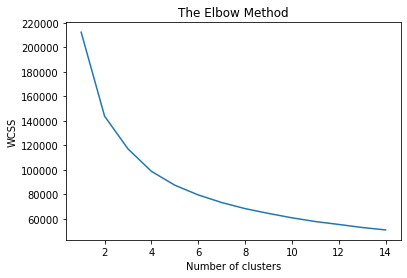

In [18]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',max_iter = 300, n_init = 10)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Grid Search of Clusters

To find a cluster model which maximizes the scoring metric, we grid search through some clustering algorithms and keep the highest-scoring model from each. 

Our custom grid search function is defined here.

In [108]:
from sklearn.metrics import calinski_harabasz_score
import itertools


def grid_search(X, algo, param_grid, scoring):
    best_model = None
    best_score = float('-inf')
    param_list = list(param_grid.values())
    param_combos = list(itertools.product(*param_list))

    for combo in param_combos:
        i = 0
        estimator_string = algo + "("
        for param in param_grid.keys():
            value = combo[i]
            if isinstance(value, str):
                estimator_string = estimator_string + param + " = '" + value + "', "
            else:
                estimator_string = estimator_string + param + " = " + str(value) + ", "
            i += 1
        
        estimator_string = estimator_string[0:(len(estimator_string)-2)] + ")"
        estimator = eval(estimator_string)
        cluster_labels = estimator.fit_predict(X)
        score = scoring(X, cluster_labels)
        print(estimator_string + " score: " + str(score))
        if score > best_score:
            best_score = score
            best_model = estimator
    return {'best_model': best_model, 'best_score': best_score}


### Definition of Clustering Parameters:

<b>k means</b>
   n_clusters - The number of clusters to form.  Also the number of centroids to generate.

<b>hierarchical agglomerative</b>:

  The parameters we are analyzing are: 

  n_clusters - The number of clusters to create.  This must be set to None, if distance_threshold is not None.

  linkage:  Can be “ward”, “complete”, “average”, “single”.  
The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion. 

When using affinity of "euclidean", we are setting linkage to the default of ”ward” which minimizes the variance of the clusters being merged.

When using other affinities, we are testing settings of: 
   -  average, which uses the average of the distances of each observation of the two sets.

   -  complete which uses the maximum distances between all observations of the two sets.

   -  single uses the minimum of the distances between all observations of the two sets.



affinity: This is the metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted, so we are setting it to "euclidean", or the default when using "ward".   For the other linkage values, we are testing with the following parameters:   “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”.


<b>gaussian mixture</b>:
n_components: The number of mixture components

covariance_type: Describes the convariance parameter to use.  These include: 
 - full - each component has its own general covariance matrix
 - tied - all components share a the same general convariance matrix
 - diag - each component has its own diagonal covariance matrix
 - spherical - each component has it's own signle varance

init_params: The method used to initialize the weights, the means and the precisions.  We are only checking K-Means which is default 


<b>spectral</b>

{'n_clusters': n_clusters: integer, optional, The dimension of the projection subspace or number of clusters.

'eigen_solver': [None, 'arpack', 'lobpcg']: The eigenvalue decomposition strategy to use.  'assign_labels': ['kmeans', 'discretize']: The strategy to use to assign labels in the embedding space. There are two ways to assign labels after the laplacian embedding. k-means can be applied and is a popular choice. But it can also be sensitive to initialization. Discretization is another approach which is less sensitive to random initialization.

'affinity': ['nearest_neighbors', 'rbf']: string or callable, default ‘rbf’. ‘nearest_neighbors’ : construct the affinity matrix by computing a graph of nearest neighbors and rbf : construct the affinity matrix using a radial basis function (RBF) kernel.

'n_neighbors': Number of neighbors to use when constructing the affinity matrix using the nearest neighbors’ method. Ignored for affinity='rbf'.



<b>dbscan</b>


'eps': [.1, .5],: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

'min_samples': [40, 80]: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

'metric': ['euclidean', 'cosine']: The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by sklearn.metrics.pairwise_distances for its metric parameter. If metric is “precomputed”, X is assumed to be a distance matrix and must be square during fit. X may be a sparse graph, in which case only “nonzero” elements may be considered neighbors.




### Set Up Grid Search for Clustering Methods and Parameters

We used a dictionary structure to map out the combinations of hyperparameters that we wanted to test. We used the algorithms Mini Batch K Means, Hierarchical Agglomerative Clustering, and Gaussian Mix Models. Although Spectral and DBSCAN were tried, they are excluded due to taking too long to run.

As determined through the elbow method, we set the range for the number of clusters to search from 3-8 clusters.

In [113]:

n_clusters = [3, 4, 5, 6, 7, 8]

#k means
kmeans_param_grid = {'n_clusters': n_clusters}

#hierarchical agglomerative
hac_param_grid = {'n_clusters': n_clusters,
                  'linkage':['ward'],
                  'affinity': ['euclidean']}
hac_param_grid_2 = {'n_clusters': n_clusters,
                    'linkage': ['complete', 'average', 'single'],
                    'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
                   }

#gaussian mixture
gmm_param_grid = {'n_components': n_clusters,
                 'covariance_type': ['spherical', 'diag', 'full'],
                 'init_params': ['kmeans']}

#spectral
spectral_param_grid = {'n_clusters': n_clusters,
                      'eigen_solver': [None, 'arpack', 'lobpcg'],
                      'assign_labels': ['kmeans', 'discretize'],
                      'affinity': ['nearest_neighbors', 'rbf'],
                      'n_neighbors': [3, 7, 21, 45]}

#dbscan
dbscan_param_grid = {'eps': [.1, .5],
                    'min_samples': [40, 80],
                    'metric': ['euclidean', 'cosine']}

candidates = {'MiniBatchKMeans': kmeans_param_grid,
             'AgglomerativeClustering': hac_param_grid_2,
             'GaussianMixture': gmm_param_grid
             #'SpectralClustering': spectral_param_grid
             #'DBSCAN': dbscan_param_grid
             }

print(candidates)

{'MiniBatchKMeans': {'n_clusters': [3, 4, 5, 6, 7, 8]}, 'AgglomerativeClustering': {'n_clusters': [3, 4, 5, 6, 7, 8], 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}, 'GaussianMixture': {'n_components': [3, 4, 5, 6, 7, 8], 'covariance_type': ['spherical', 'diag', 'full'], 'init_params': ['kmeans']}}


### Run Grid Search

We include all the variables, including the label-encoded ordinal variables, because we believe them all to be relevant in determining similarity between data points. To reduce run time, we sampled a random 5000 to do our clustering grid search. We scaled the data to ensure that no variable unintentionally dominates the clustering.

In [114]:

#cluster with all the variables
X = df[["age","cholesterol", "gluc", "smoke", "alco", "ap_hi", "ap_lo", "bmi", "cardio", "weight", "height"]].sample(n=5000).values

#scale the data
std_scl = StandardScaler()
scl_obj = std_scl.fit(X)
X_scaled = scl_obj.transform(X)

#keeping the best model from each algorithm
bests = []
for estimator in candidates:
    best = grid_search(X_scaled, estimator, candidates[estimator], calinski_harabasz_score)
    bests.append(best)
    



MiniBatchKMeans(n_clusters = 3) score: 768.4645667529404
MiniBatchKMeans(n_clusters = 4) score: 662.8784098697239
MiniBatchKMeans(n_clusters = 5) score: 751.3285399971508
MiniBatchKMeans(n_clusters = 6) score: 722.5078330151049
MiniBatchKMeans(n_clusters = 7) score: 767.935775221024
MiniBatchKMeans(n_clusters = 8) score: 596.3504975000845
AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity = 'euclidean') score: 307.25182309308417
AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity = 'l1') score: 396.2685929704811
AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity = 'l2') score: 307.25182309308417
AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity = 'manhattan') score: 396.2685929704811
AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity = 'cosine') score: 615.0746240413929
AgglomerativeClustering(n_clusters = 3, linkage = 'average', affinity = 'euclidean') score: 30.67374515031679
Agglomera

### Display Best Clustering Model Scores

Above, the Calinski-Harabasz score is printed for all the estimators. We keep the top model for each algorithm, as shown below. In all cases, our grid search picked 3 for the number of clusters. K Means comes out with the highest Calinski-Harabasz score.

In [115]:
print(bests)

[{'best_model': MiniBatchKMeans(n_clusters=3), 'best_score': 768.4645667529404}, {'best_model': AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=3), 'best_score': 755.5964015780107}, {'best_model': GaussianMixture(covariance_type='spherical', n_components=3), 'best_score': 737.2874650413554}]


### Graph of Three Best Clustering Score

Text(0.5, 1.0, 'Best Scores per Model')

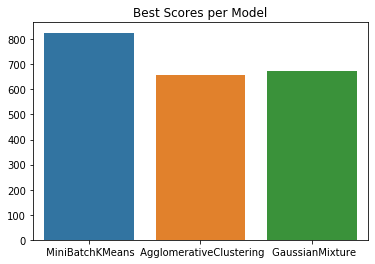

In [161]:
scorex=[]
model2=[]
for i in bests:
    newx = str(i)
    pt1, modelx = newx.split("'best_model':")
    model1, rest= modelx.split("(")
    pt1, score1 = newx.split("'best_score':")
    scorex.append(float(score1[1:10]))
    model2.append(model1)
    
  
sns.barplot(x=model2, y=scorex, data=df_viz)
plt.title('Best Scores per Model')

In [ ]:
scorex=[]
model2=[]
for i in bests:
    newx = str(i)
    pt1, modelx = newx.split("'best_model':")
    model1, rest= modelx.split("(")
    pt1, score1 = newx.split("'best_score':")
    scorex.append(float(score1[1:10]))
    model2.append(model1)
    
  
sns.barplot(x=model2, y=scorex, data=df_viz)
plt.title('Best Scores per Model')

# Visualizing the Top Models

We plot each of the clustering models across pairs of variables, to visualize how the distribution of the clusters relate to our variables.  


MiniBatchKMeans(n_clusters=3)


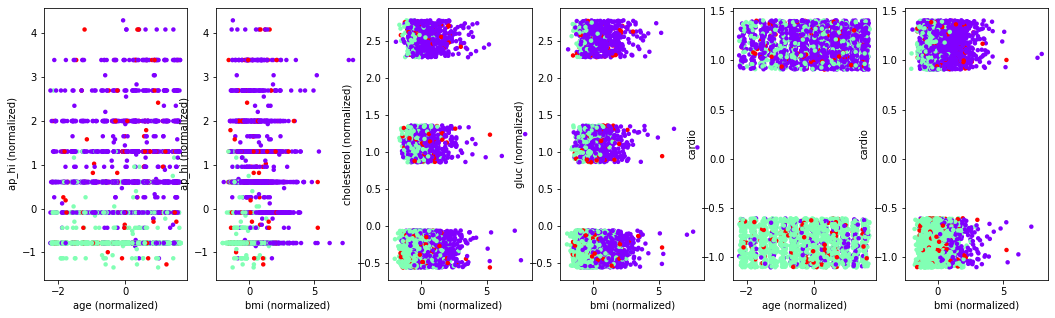

AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=3)


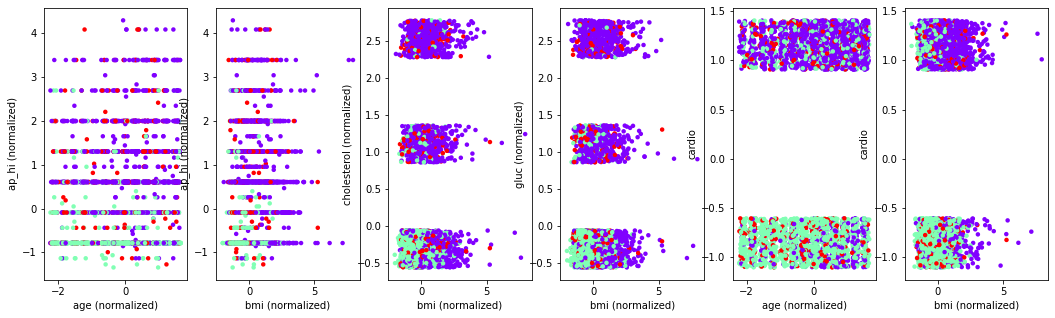

GaussianMixture(covariance_type='spherical', n_components=3)


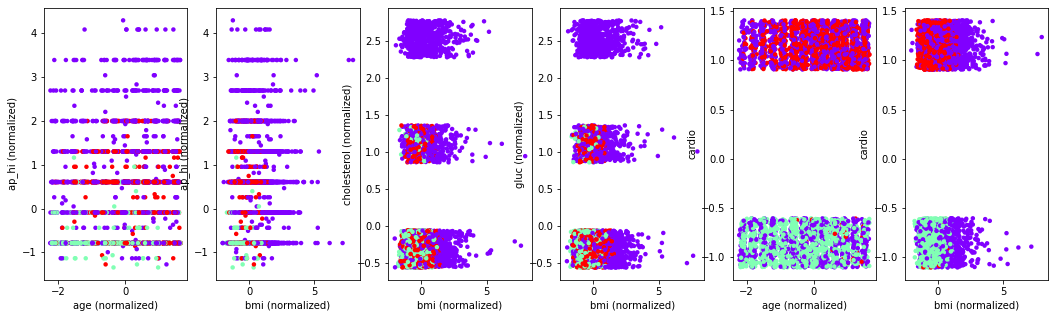

In [116]:
#The order of variables in X are:
# "age","cholesterol", "gluc", "smoke", "alco", "ap_hi", "ap_lo", "bmi", "cardio", "weight", "height"

for algo in bests:
    model = algo['best_model']
    cluster_labels = model.fit_predict(X_scaled)
    
    print(model)
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1,6,1)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 5], c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('age (normalized)'), plt.ylabel('ap_hi (normalized)')
    
    plt.subplot(1,6,2)
    plt.scatter(X_scaled[:, 7], X_scaled[:, 5], c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('bmi (normalized)'), plt.ylabel('ap_hi (normalized)')

    plt.subplot(1,6,3)
    plt.scatter(X_scaled[:, 7], X_scaled[:, 1]+np.random.random(X_scaled[:, 1].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('bmi (normalized)'), plt.ylabel('cholesterol (normalized)')
    
    plt.subplot(1,6,4)
    plt.scatter(X_scaled[:, 7], X_scaled[:, 1]+np.random.random(X_scaled[:, 2].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('bmi (normalized)'), plt.ylabel('gluc (normalized)')
    
    plt.subplot(1,6,5)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 8]+np.random.random(X_scaled[:, 8].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('age (normalized)'), plt.ylabel('cardio')

    plt.subplot(1,6,6)
    plt.scatter(X_scaled[:, 7], X_scaled[:, 8]+np.random.random(X_scaled[:, 8].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('bmi (normalized)'), plt.ylabel('cardio')
    plt.show()

In [ ]:
    
    plt.subplot(1,6,5)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 8]+np.random.random(X_scaled[:, 8].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('age (normalized)'), plt.ylabel('cardio')


### Cluster Visualization and Description of Results   

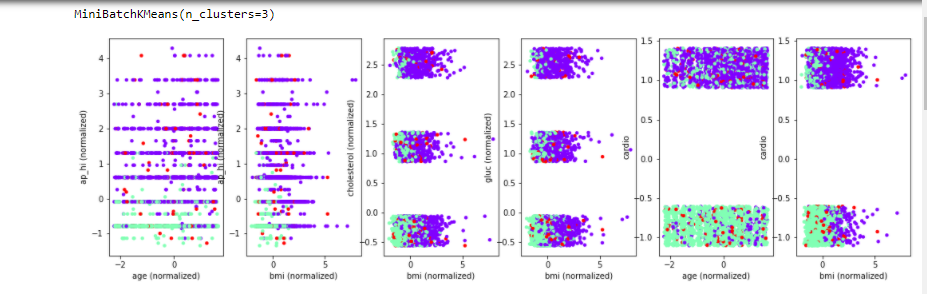

 
#### Kmean: These are three cluster graphs.

**age- ap_hi:** 

*Lower ap_hi:* The green cluster is more dominant at a lower ap_hi. 

*Higher ap_hi:* Purple cluster are more visible at higher age and higher ap_hi. A red cluster is sprinkled 
across the chart.

**bmi-ap_hi:** 

*Lower ap_hi:* Green cluster is visible at low bmi and lower ap_hi. However, purple cluster becomes more  visible at higher bmi zone.  

*Higher ap_hi:* Purple cluster is more dominated at higher ap_hi.

*Red Cluster:* A red cluster is sprinkled across the chart.


**bmi-cholesterol:** 

*Low Cholesterol:* At lower bmi green is prominent. However, purple becomes dominant at higher bmi. 

*Medium Cholesterol:* It starts with green cluster and swings to purple at we move to higher bmi.

*Higher Cholesterol:* At higher cholesterol, a purple cluster is very prominent. It starts with very little green and moves to purple dominance. Purple cluster is very dense in the high cholesterol zone. 

*Red Cluster:* A red cluster is sprinkled across the chart.


**bmi-gluc:** This graph distribution is very similar to the bmi-cholestrol distribution.

*Low gluc:* At lower bmi green is prominent. However, purple becomes dominant at higher bmi. 

*Medium gluc:* It starts with green cluster and swings to purple as we move to higher bmi.

*Higher gluc:* At higher gluc, a purple cluster is very prominent. It starts with very little green (at lower bmi) and moves to purple dominance. Purple cluster is very dense in the high cholesterol zone. 

*Red Cluster:* A red cluster is sprinkled across the chart.


**age-cardio:**

*Low Cardio:* Green cluster indicates no cardio issue, which is spread across all ages. Purple is significantly less visible in the lower area of the graph. 

*High Cardio:* The upper area of the chart is a purple dominant cluster. Green cluster is more visible when Cardio is lower or cardio risk is lower. On higher Cardio, purple stays a dominant cluster.


**bmi-cardio:** 

*Low Cardio:* Green is the dominant cluster at lower Cardio,however, purple cluster is showing y=up at higher bmi.

*High Cardio:* Purple is dominant at higher Cardio. However, the green cluster shows up in a lower bmi zone even with high Cardio.




**Summary:** Purple cluster appears to be an indicator of cardio disease or high cardio risk. As observed in graphs, the purple cluster is more prominent in high bmi and high gulc zone. Also, cholesterol and ap_hi show more purple in the high bmi zone. So, we can conclude high bmi, high gulc, high ap_hi, and high cholesterol are associated with Cardio. Purple cluster show association with either person has cardio or at risk of getting the cardio disease. In contrast, green is an indicator of no cardio issues or the low possibility of cardio problems. Red cluster is sprinkled all over the chat so appears very unconclusive. 




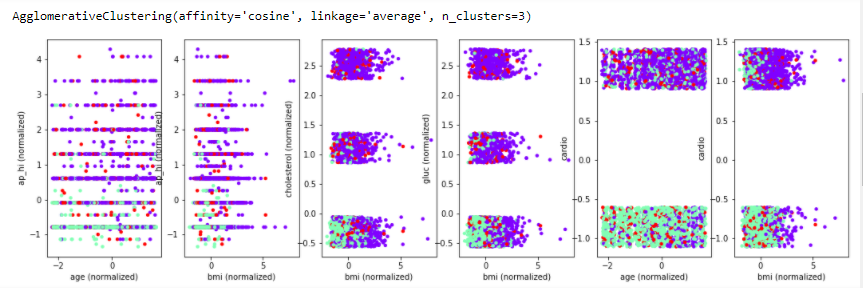

##### Agglomerative Clustering: These graphs contains three clusters.

**age- ap_hi:** Not very conclusive graph as green, red and purple are very mix and not very clean delineation. 

*Low ap_hi:* The green cluster is visible at a lower age, and low ap_hi 

*High ap_hi:* Purple cluster are more visible at higher age and higher ap_hi. 

*Red Cluster:* Red cluster is sprinkled across the chart.

**bmi-ap_hi:** Clustering is very similar to age-ap_hi charts. 

*Low ap_hi:* Green cluster are in low bmi and low ap_hi. 

*High ap_hi:* The purple cluster is more dominated at high BP and high ap_hi. The purple cluster is also in the low bmi area. Also, people with low bmi and high ap_hi show purple.

*Red Cluster:* Red cluster is sprinkled across the chart.

**bmi-cholesterol:** Green cluster is visible in low bmi and low cholesterol area.  

*High Cholesterol:* At higher cholesterol, purple cluster is very prominent. 

*Medium Cholesterol:* At medium cholesterol, a purple cluster is visible with green and red sprinkled. Lower bmi show presence of green cluster samples. 

*Low Cholesterol:* In the low cholesterol and lower bmi area, the green cluster is more prevalent. 
Purple is dominant on higher bmi. 

*Red Cluster:*  The red cluster is sprinkled across the chart. 


**bmi-gulc:** This graph distribution is very similar to the bmi-cholestrol distribution.

*High gulc:* At higher gulc, purple cluster is very prominent. 

*Medium gulc:* At medium gulc, a purple cluster is visible with green and red sprinkled. Lower bmi show presence of green cluster samples. 

*Low gulc:* In the low gulc and lower bmi area, the green cluster is more prevalent. 
Purple is dominant on higher bmi. 

*Red Cluster:*  The red cluster is sprinkled across the chart. 

**age-cardio:** 

*Low Cardio:* Green cluster indicates no cardio issue, which is spread across all ages. Green cluster is more visible in the area when cardio is lower. However, purple is visible at low cardio and high age.

*Upper Cardio:* The upper area of the chart is a purple dominant cluster. On higher cardio, purple stays a dominant cluster. 

*Red Cluster:* Red cluster is sprinkled across both high and low Cardio. 

**bmi-cardio:** 

*Lower Cardio:* Green is the dominant cluster at lower cardio. However, purple samples are visible at high bmi. 

*High Cardio:* Purple is dominant at higher Cardio. However, there is presence of green cluster in higher cardio with low bmi. 

*Red Cluster:* Red cluster is sprinkled across both high and low Cardio. 



**Summary:** Purple cluster appears to be an indicator of cardio disease. As observed in graphs, the purple cluster is more prominent in high bmi and high gulc zone. Also, cholesterol and ap_hi show more purple in the high bmi zone (as per common knowledge high bmi, high ap_hi and high cholesterol are associated with cardio issues). So, we can conclude high bmi, high gulc, high ap_hi, and high cholesterol are associated with Cardio. Purple show association with either person has cardio or at risk of getting the cardio disease. In contrast, green is an indicator of no cardio issues or the low possibility of cardio problems. Red cluster is sprinkled all over the chat so appears very unconclusive. 


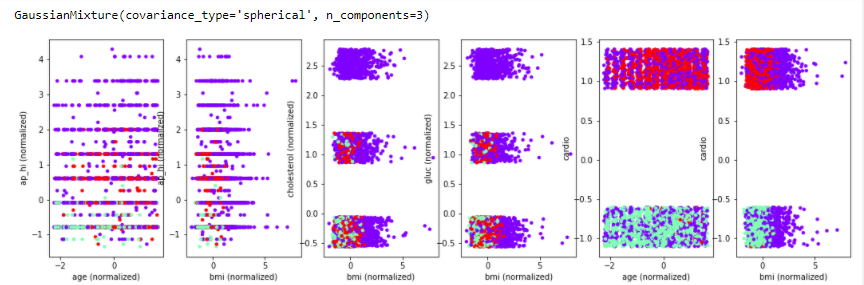

#### Gaussian Mixture Clustering: These are three cluster graphs.

**age- ap_hi:** Not very conclusive graph as green, red and purple are very mix and not very clean delineation. 

*Low ap_hi:* The green cluster is visible at a lower age, and low ap_hi 

*High ap_hi:* Purple cluster are more visible at higher age and higher ap_hi. 

*Red Cluster:* Red cluster appears across all the ages and in low-medium ap_hi. 


**bmi-ap_hi:** Clustering is very similar to agi-ap_hi charts. Except red cluster is not visible in higher ap_hi values.

*Low ap_hi:* Green cluster are in low bmi and low ap_hi. 

*High ap_hi:* The purple cluster is more dominated at high BP and high ap_hi. The purple cluster is also in the low bmi area. Also, people with low bmi and high ap_hi show purple.

*Red Cluster:* Red cluster is in low-medium ap_hi and low-medium BMI. 


**bmi-cholesterol:** Green cluster is visible in low bmi and low cholesterol area.  

*High Cholesterol:* At higher cholesterol, purple cluster is very prominent. No green or red cluster is visible. 

*Medium Cholesterol:* At medium cholesterol, a purple cluster is visible with green and red sprinkled. Lower bmi shows the presence of green cluster samples. 

*Low Cholesterol:* In the low cholesterol and lower bmi area, the green cluster is more prevalent. 
Purple is dominant on higher bmi. 

*Red Cluster:* The red cluster shows up in lower and middle cholesterol lower bmi zones. 


**bmi-gluc:** This graph distribution is very similar to the bmi-cholestrol distribution.

*High gluc:* At higher gluc, purple cluster is very prominent. Green and red samples are not visible in high gluc area.

*Medium gluc:* At medium gluc, a purple cluster is visible with green and red sprinkled. Lower bmi show presence of green cluster samples. 

*Low gluc:* In the low gluc and lower bmi area, the green cluster is more prevalent. Purple is dominant on higher bmi. 


*Red Cluster:*  The red cluster is in low-medium BMI and low-medium gluc. 


**age-cardio:** 

*Low Cardio:* Green cluster indicates no cardio issue, which is spread across all ages. Green cluster is more visible in the area when cardio is lower. However, purple is visible at low cardio and high age.

*Upper Cardio:* The upper area of the chart is a purple and red dominant cluster. On higher cardio, purple stays a dominant cluster. 

*Red Cluster:* Red cluster is mixed with purple in higher cardio zone, and is not present in the non-cardio group. 

**bmi-cardio:** 

*Lower Cardio:* Green is the dominant cluster at lower cardio. However, purple samples are visible at high bmi. 

*High Cardio:* Purple is dominant at higher cardio and high bmi. Red cluster is present  in low bmi area.  

*Red Cluster:* Red cluster prominent at low bmi and high cardio.  


#### Conclusion: 
Purple and red clusters appear to be an indicator of cardio disease. As observed in graphs, the purple cluster is more prominent in high bmi and high gulc zone. Also, cholesterol and ap_hi show more purple in the high bmi zone (as per common knowledge high bmi, high ap_hi and high cholesterol are associated with cardio issues). So, we can conclude high bmi, high gulc, high ap_hi, and high cholesterol are associated with Cardio. Purple and red show association with either person has cardio or at risk of getting the cardio disease. In contrast, green is an indicator of no cardio issues or the low possibility of cardio problems. Red cluster represents those who have cardio but have low-medium BMI and low-medium blood pressure.


# Using the Gaussian Mixture on Whole Dataset

From our analysis of the clusters, we determined that we like the Gaussian Mixture clusters the best. Despite it having the lowest score, the Gaussian Mixture separated the data in an interesting way by breaking out those with heart disease into those with high BMI/blood pressure (the purple cluster), and those with low-medium BMI/blood pressure (the red cluster). To run with that one and examine it further, we created the Gaussian Mixture model using the entire dataset instead of just a sample.

In [9]:

X = df[["age","cholesterol", "gluc", "smoke", "alco", "ap_hi", "ap_lo", "bmi", "cardio", "weight", "height"]].values

std_scl = StandardScaler()
scl_obj = std_scl.fit(X)

X_scaled = scl_obj.transform(X)
cluster_model = GaussianMixture(covariance_type='spherical', n_components=3)

cluster_labels = cluster_model.fit_predict(X_scaled)


As a sanity check, we plot the same plots as before with the new model, to make sure it separates the data in a similar way to what we were expecting. On a visual inspection, the new clusters appear to be similar to the old ones.

GaussianMixture(covariance_type='spherical', n_components=3)


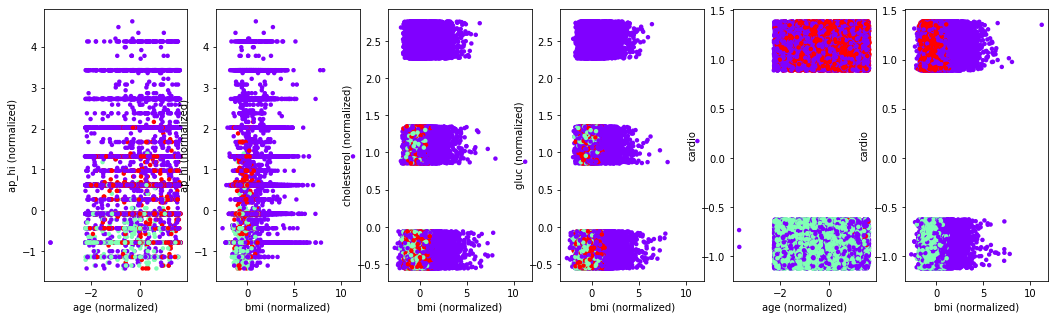

In [10]:
print(cluster_model)
plt.figure(figsize=(18, 5))

plt.subplot(1,6,1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 5], c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age (normalized)'), plt.ylabel('ap_hi (normalized)')

plt.subplot(1,6,2)
plt.scatter(X_scaled[:, 7], X_scaled[:, 5], c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('bmi (normalized)'), plt.ylabel('ap_hi (normalized)')

plt.subplot(1,6,3)
plt.scatter(X_scaled[:, 7], X_scaled[:, 1]+np.random.random(X_scaled[:, 1].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('bmi (normalized)'), plt.ylabel('cholesterol (normalized)')

plt.subplot(1,6,4)
plt.scatter(X_scaled[:, 7], X_scaled[:, 1]+np.random.random(X_scaled[:, 2].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('bmi (normalized)'), plt.ylabel('gluc (normalized)')

plt.subplot(1,6,5)
plt.scatter(X_scaled[:, 0], X_scaled[:, 8]+np.random.random(X_scaled[:, 8].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age (normalized)'), plt.ylabel('cardio')

plt.subplot(1,6,6)
plt.scatter(X_scaled[:, 7], X_scaled[:, 8]+np.random.random(X_scaled[:, 8].shape)/2, c=cluster_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('bmi (normalized)'), plt.ylabel('cardio')
plt.show()

# Modeling the Cluster Labels

To gain insight into what comprises the clusters, we created a logistic regression model on the scaled data with the cluster labels as targets. This allows us to assess the relationships of the variables to the clusters by examining the weights of the logistic regression.

As a sanity check to make sure the logistic regression model does a good job of representing the clusters, we do 5-fold cross validation to check the accuracy of a logistic regression for predicting each cluster. We turned the cluster labels into dummies so that we could see the accuracy for each cluster. Based on the 5-fold cross validations, we see that the accuracies range from 91% to 97%, so we feel confident that the logistic regression is representing our clusters well.

Because this logistic model is not intended for prediction but for analysis, we do not make a distinction to fit the scaling on the train data separately from the test data. In addition, in the analysis of the weights of the features, we will not use these same 3 models from the cross-validation, but we condense the models into one model, knowing that by default sklearn's LogisticRegression will perform one-verses-rest classification when given a multiclass target.

In [51]:
from sklearn.linear_model import LogisticRegression

cluster_label_dummies = pd.get_dummies(cluster_labels)
cluster_0 = cluster_label_dummies[0]
cluster_1 = cluster_label_dummies[1]
cluster_2 = cluster_label_dummies[2]

logistic_reg = LogisticRegression()

score_0 = cross_val_score(logistic_reg, X_scaled, cluster_0)
score_1 = cross_val_score(logistic_reg, X_scaled, cluster_1)
score_2 = cross_val_score(logistic_reg, X_scaled, cluster_2)

print(score_0)
print(score_1)
print(score_2)

[0.91518236 0.91603053 0.9112242  0.91366635 0.91215834]
[0.97031383 0.96974837 0.96701536 0.97031103 0.96757776]
[0.94439732 0.94505702 0.94543398 0.94363808 0.94156456]


# Weights of the Features

We plot the weights of the features from the logistic regression to visualize them. From the plots we can see that:

Cluster 0 is made of:
* high BMI
* low weight
* smokers

Cluster 1 is made of:
* low BMI
* high weight
* not having heart disease

Cluster 2 is made of:
* having heart disease
* nonsmokers

The make up of these clusters is somewhat unintuitive, that cluster 0 is made up of people with high BMI and low weight, and cluster 1 is made up of people with low BMI and high weight, since those are not common combinations to have together. Also, ap_hi is not much represented in the logistic regression weights. A deeper dive would be needed to analyze why these weights are what they are.

[[-0.13286333  1.23799945  1.26954179  2.39858251  1.89829051  1.09026611
   0.42478762  4.54206054  0.41779717 -2.83355611  2.04650509]
 [-0.20539593 -0.63045448 -0.84260026 -1.27725347 -0.9719113  -1.08521715
  -0.29738047 -4.23197198 -3.74061178  2.95269158 -1.98012747]
 [ 0.33825926 -0.60754497 -0.42694154 -1.12132904 -0.92637922 -0.00504896
  -0.12740714 -0.31008856  3.32281462 -0.11913546 -0.06637762]]


/Users/tina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


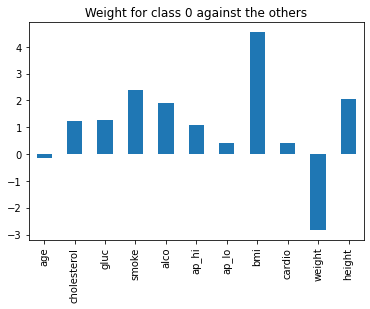

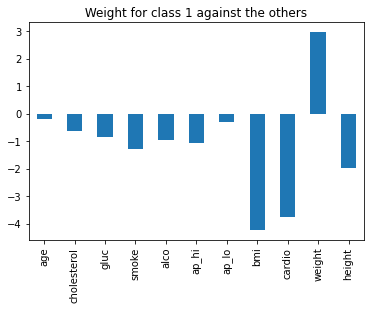

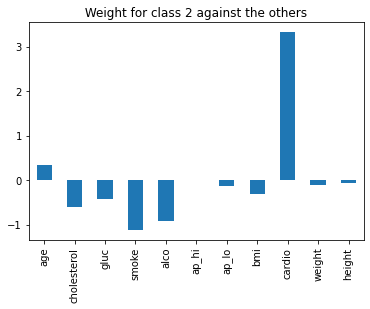

In [49]:
logistic_reg.fit(X_scaled, cluster_labels)

print(logistic_reg.coef_)

variable_names = ["age","cholesterol", "gluc", "smoke", "alco", "ap_hi", "ap_lo", "bmi", "cardio", "weight", "height"]
 
class_names = [0, 1, 2]
for i in class_names:
    weights = pd.Series(logistic_reg.coef_[i],index= variable_names)
    weights.plot(kind='bar')
    title= " Weight for class " + str(class_names[i]) + " against the others "
    plt.title(title)
    plt.show()
    

# =========== CLUSTERING TO MAXIMIZE ACCURACY =============

# Model selection

Below you can see the Knn, Logistic Regression (LR), and Random Forest (RF) model. The LR and Knn are the best models, we choose to use the LR model. The best parameter and variables found in previous labs were used. 

# Knn analysis

In [16]:
y = df1['cardio']
X = df1[["ap_hi", "bmi", 'age', "ap_lo", "cholesterol"]]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X)
X = scl_obj.transform(X)

cv = StratifiedKFold(n_splits=10)

clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, n_neighbors=39)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  71.53786397763406 +- 0.40603904400765234


# Random Forest Analysis

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = df1['cardio']
X = df1[["ap_hi", "bmi", 'age', "ap_lo", "cholesterol"]]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X)
X = scl_obj.transform(X)

cv = StratifiedKFold(n_splits=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  68.34858482872181 +- 0.4344006320374269


# Logistic Regression

In [18]:
y = df1['cardio']

X = df1[["ap_hi", "bmi", 'age', "ap_lo", "cholesterol"]]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X)
X = scl_obj.transform(X)

cv = StratifiedKFold(n_splits=10)

clf= LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga')

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  71.37572575326702 +- 0.47281269207059246


# Use the cluster to see if it improves the model

We clustered the continuous variables using KMean clustering.  We used the cluster labels along with cholesterol as features for a Logictic Regresson model to predict cardiac heart disease.  The continous and categorical variables were chosen from the analysis done in Lab 2. After preforming this test with KMeans clustering, additional analysis was performed with different clustering algorithms. 

# Kmean analysis

Kmean algorithm: 

1.	To begin, we first select a number of classes/groups to use and randomly initialize their respective center points. To figure out the number of classes to use, it’s good to take a quick look at the data and try to identify any distinct groupings. The center points are vectors of the same length as each data point vector and are the “X’s” in the graphic above.

2.	Each data point is classified by computing the distance between that point and each group center, and then classifying the point to be in the group whose center is closest to it.

3.	Based on these classified points, we recompute the group center by taking the mean of all the vectors in the group.

4.	Repeat these steps for a set number of iterations or until the group centers don’t change much between iterations. You can also opt to randomly initialize the group centers a few times, and then select the run that looks like it provided the best results.


K-Means has the advantage that it’s pretty fast, as all we’re really doing is computing the distances between points and group centers; very few computations! It thus has a linear complexity O(n).
On the other hand, K-Means has a couple of disadvantages. One disadvantage of K-Means is that the user has to determine the number of groups/clusters, which isn’t always trivial.  Ideally with a clustering algorithm we’d want it to figure those out for us because the point of it is to gain some insight from the data.   Another challenge with K-means is that it starts with a random choice of cluster centers and therefore it may yield different clustering results on different runs of the algorithm. Thus, the results may not be repeatable and lack consistency. Other cluster methods are more consistent.



In [19]:
cv = StratifiedKFold(n_splits=10)
clf = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga')

X1 = df1[["ap_hi", "bmi", 'age', "ap_lo"]]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X1)
X_scaled1 = scl_obj.transform(X1)

X = df1[['cholesterol']]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X)
X_scaled = scl_obj.transform(X)

cls = KMeans(n_clusters=3, init='k-means++',random_state=1)
cls.fit(X_scaled1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df1['cardio']
X = X_scaled 
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for BP and BMI)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for BP and BMI)=  67.15357145990458 +- 0.6358708769899213


We decided to use accuracy as the metric to compare the different model, metric which we used in the lab 2. Kmean accuracy 67%

In [20]:
X.shape

(53053, 4)

# Look at different cluster number

The K-Means models were tested with different values for the number of clusters. The best accuracy for the predictive model was acheived with 10 clusters.    


In [21]:
clf = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga')
n_fare=8
params = []
for n_fare in range(8,12):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
    cls_fam.fit(X_scaled1)
    newfeature = cls_fam.labels_ # the labels from kmeans clustering

    y = df1['cardio']
    X = X_scaled
    X = np.column_stack((X,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

    print ("Clusters",n_fare,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


Clusters 8 Average accuracy =  69.14780384279932 +- 0.4730872423770542
Clusters 9 Average accuracy =  68.83490889529953 +- 0.5754078046214075
Clusters 10 Average accuracy =  70.20336595545407 +- 0.40952770733894417
Clusters 11 Average accuracy =  70.26556929056387 +- 0.4170440497508268


# Plot

We can see from the plot that there is a group of patients with high systolic blood pressure and low BMI. We see that the same group of patients with higher systolic blood pressure have a higher age. The diastolic blood pressure also behaves the same way as the systolic blood pressure. The higher diastolic blood pressure is in the group of low bmi and higher age. 

The weight and height which is part of the bmi, behave the same way as bmi in relation to systolic and diastolic blood pressure, please see the graph that show the weight and height in relation to systolic and diastolic blood pressure below.

The graph about bmi and age is not that helpful.

Also we see patient who are shorter have higher weight, which show that there is a great amount of patient with height bmi in other word obese.

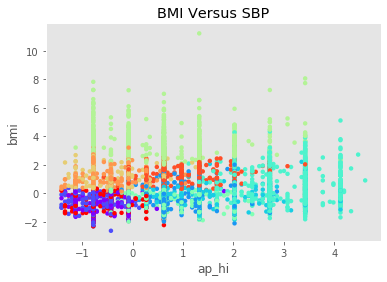

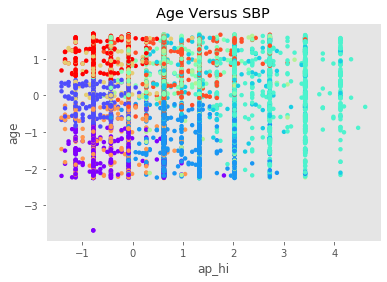

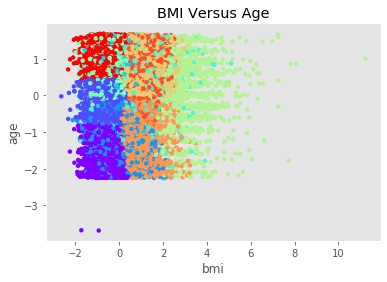

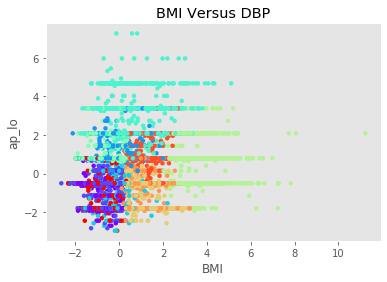

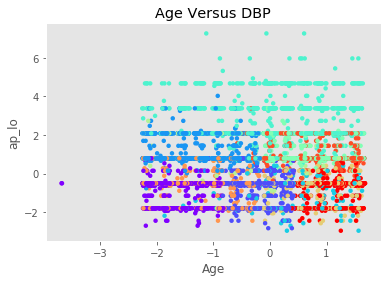

In [22]:
plt.style.use("ggplot")

%matplotlib inline

plt.scatter(X_scaled1[:, 0], X_scaled1[:, 1], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.grid()
plt.title('BMI Versus SBP')
plt.show()

plt.scatter(X_scaled1[:, 0], X_scaled1[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.grid()
plt.title('Age Versus SBP')
plt.show()

plt.scatter(X_scaled1[:, 1], X_scaled1[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('bmi'), plt.ylabel('age')
plt.grid()
plt.title('BMI Versus Age')
plt.show()

plt.scatter(X_scaled1[:, 1], X_scaled1[:, 3], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('BMI'), plt.ylabel('ap_lo')
plt.grid()
plt.title('BMI Versus DBP')
plt.show()

plt.scatter(X_scaled1[:, 2], X_scaled1[:, 3], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('ap_lo')
plt.grid()
plt.title('Age Versus DBP')
plt.show()


# Another Kmean analysis

Analysis was carried out with the weight and height instead of the bmi (which combines the 2 mentioned variables) to evaluate if the clustering can provide better information.  However, this turned out not to be the case, as the accuracy was lower at 69%.  

In [23]:
dfo = df[["age","cholesterol", "gluc", "smoke", "alco", "ap_hi", "ap_lo", "bmi", "cardio", "weight", "height"]]

cv = StratifiedKFold(n_splits=10)
clf = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga')

X0 = dfo[["weight", "height", "ap_hi", "age", "ap_lo"]]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X0)
X_scaled10 = scl_obj.transform(X0)

X = dfo[['cholesterol']]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X)
X_scaled0 = scl_obj.transform(X)

cls = KMeans(n_clusters=10, init='k-means++',random_state=1)
cls.fit(X_scaled10)
newfeature = cls.labels_ # the labels from kmeans clustering

y0 = dfo['cardio']
X0 = X_scaled0 
X0 = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X0,y=y0,cv=cv)

print ("Average accuracy (with kmeans for BP and BMI)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for BP and BMI)=  68.99892503046236 +- 0.5524782776490337


# Find the best K

The best k number in this model of Kmean with differents variables in the cluster in comparison to the previous one, show against that the number 10 of cluster is the amount of cluster that gives the best accuracy, 69%. But this accuracy is lower than the previous model with bmi instead of weight and hieight separetely, previous model accuaracy is 70%.

In [24]:
clf = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga')
n_fare=8
params = []
for n_fare in range(8,12):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
    cls_fam.fit(X_scaled10)
    newfeature = cls_fam.labels_ # the labels from kmeans clustering

    y = df1['cardio']
    X = X_scaled0
    X = np.column_stack((X,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare, acc.mean()*100,acc.std()*100)) # save state

    print ("Clusters",n_fare,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


Clusters 8 Average accuracy =  68.25438279659849 +- 0.43754527027556084
Clusters 9 Average accuracy =  68.85941656872761 +- 0.5387937378709668
Clusters 10 Average accuracy =  68.99892503046236 +- 0.5524782776490337
Clusters 11 Average accuracy =  68.87262978987965 +- 0.4597247221088863


# Plot the second Kmean analysis

This is the plot with weight and height instead of bmi.

As mentioned in the previous plot: We can see from that plot that there is a group of patients with high systolic blood pressure and low bmi. We see that the same group of patient with higher systolic blood pressure have a higher age. The diastolic blood pressure also behaves the same way as the systolic blood pressure. The higher diastolic blood pressure is in the group of low bmi and higher age.

The weight and height which is part of the bmi, behave the same way as bmi in relation to systolic and diastolic blood pressure, please see the graph that show the weight and height in relation to systolic and diastolic blood pressure below.


Also we see patient who are shorter have higher weight, which show that there is a great amount of patient with height bmi, in other word ther is a great amount of obese patients obese.

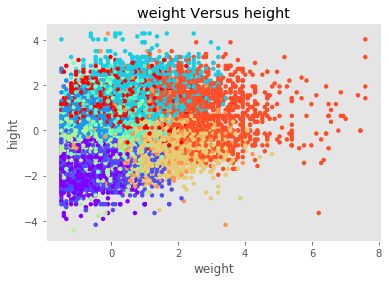

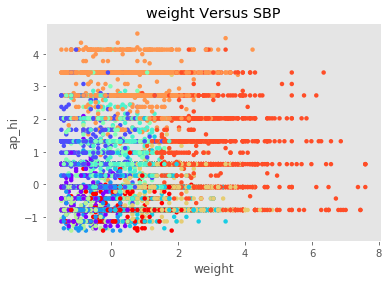

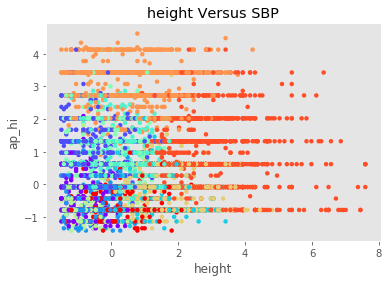

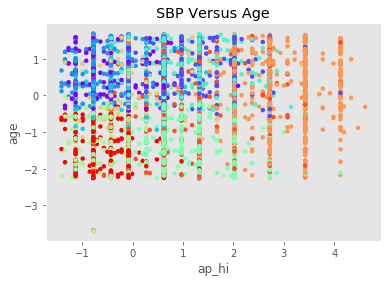

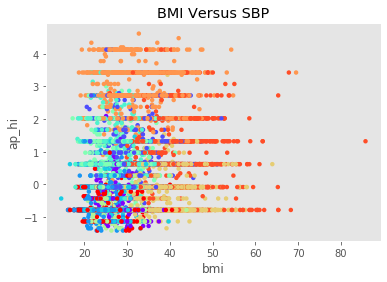

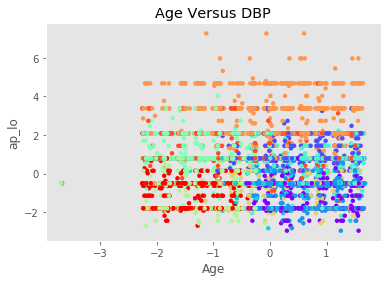

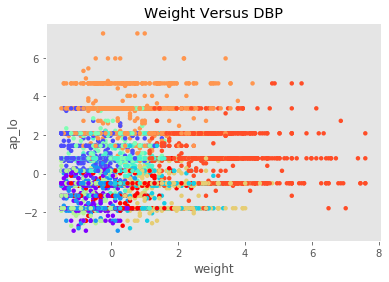

In [25]:
plt.style.use("ggplot")

%matplotlib inline

plt.scatter(X_scaled10[:, 0], X_scaled10[:, 1], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('weight'), plt.ylabel('hight')
plt.grid()
plt.title('weight Versus height')
plt.show()

plt.style.use("ggplot")

%matplotlib inline

plt.scatter(X_scaled10[:, 0], X_scaled10[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('weight'), plt.ylabel('ap_hi')
plt.grid()
plt.title('weight Versus SBP')
plt.show()

plt.scatter(X_scaled10[:, 0], X_scaled10[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('height'), plt.ylabel('ap_hi')
plt.grid()
plt.title('height Versus SBP')
plt.show()

plt.scatter(X_scaled10[:, 2], X_scaled10[:, 3], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.grid()
plt.title('SBP Versus Age')
plt.show()


plt.scatter(dfo["bmi"], X_scaled10[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('bmi'), plt.ylabel('ap_hi')
plt.grid()
plt.title('BMI Versus SBP')
plt.show()


plt.scatter(X_scaled10[:, 3], X_scaled10[:, 4], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age'), plt.ylabel('ap_lo')
plt.grid()
plt.title('Age Versus DBP')
plt.show()

plt.scatter(X_scaled10[:, 0], X_scaled10[:, 4], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('weight'), plt.ylabel('ap_lo')
plt.grid()
plt.title('Weight Versus DBP')
plt.show()

# Scaled and less data for the Agglomerative and the DBSCAN

Now we prepare the data to run DBSCAN and Agglomerative clustering algorithms.  We used half of the observations (25,000) because of the amount of time that it takes to run the model.  Our plan was that if we saw improvement in comparison to the kmean we will run with the whole dataset. However, we did not see improvement.

In [26]:
df2= df1.iloc[0:25000, :]
df2

X2 = df2[["ap_hi", "bmi", 'age',"ap_lo" ]]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X2)
X_scaled2 = scl_obj.transform(X2)

X3 = df2[['cholesterol']]
std_scl = StandardScaler()
scl_obj = std_scl.fit(X3)
X_scaled3 = scl_obj.transform(X3)

y1 = df2['cardio']

# Trying with AgglomerativeClustering

Hierarchical clustering algorithms fall into 2 categories: top-down or bottom-up. Bottom-up algorithms treat each data point as a single cluster at the outset and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster that contains all data points. Bottom-up hierarchical clustering is therefore called hierarchical agglomerative clustering or HAC. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. 

Hierarchical clustering does not require us to specify the number of clusters and we can even select which number of clusters looks best since we are building a tree. Additionally, the algorithm is not sensitive to the choice of distance metric; all of them tend to work equally well whereas with other clustering algorithms, the choice of distance metric is critical. A particularly good use case of hierarchical clustering methods is when the underlying data has a hierarchical structure and you want to recover the hierarchy; other clustering algorithms can’t do this. These advantages of hierarchical clustering come at the cost of lower efficiency, as it has a time complexity of O(n³), unlike the linear complexity of K-Means and GMM.

We run the below peace of code to find the best link (complete, ward, or average), and the different number of cluster, which is the place where we cut in the dendogram. The best model for agglomerative clustering is with the ward link and the number of cluster of 10. But it is not better than Kmean, and the clustering visualization is not better than the Kmean visualization. The reason why the agglomerative clustering algorithm does not show better clustering than the Kmean probably is due to the fact that our data dees not follow a hyerarchical shape, which is the type of data in which the agglomerative clustering model behaive the best.

In [27]:
%%time 

from sklearn.cluster import AgglomerativeClustering


params = []
for link in ['ward', 'complete', 'average']:
    for n_fare in range(4,11):

        # append on the clustering
        cls_f = AgglomerativeClustering(n_clusters=n_fare, linkage=link)
        cls_f.fit(X_scaled2)
        newfeature = cls_f.labels_ # the labels from kmeans clustering

        y = y1
        X = X_scaled3
        X = np.column_stack((X,pd.get_dummies(newfeature)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_fare,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 4 ward Average accuracy =  68.9680174348828 +- 0.7257867811810094
C= 5 ward Average accuracy =  68.9680174348828 +- 0.7257867811810094
C= 6 ward Average accuracy =  68.9680174348828 +- 0.7257867811810094
C= 7 ward Average accuracy =  69.895931183349 +- 0.4778755162307413
C= 8 ward Average accuracy =  70.12393601982977 +- 0.4497490351855106
C= 9 ward Average accuracy =  70.12393601982977 +- 0.4497490351855106
C= 10 ward Average accuracy =  70.12393601982977 +- 0.4497490351855106
C= 4 complete Average accuracy =  64.30008548801368 +- 0.7052450281934077
C= 5 complete Average accuracy =  64.30008548801368 +- 0.7052450281934077
C= 6 complete Average accuracy =  64.30008548801368 +- 0.7052450281934077
C= 7 complete Average accuracy =  64.30008548801368 +- 0.7052450281934077
C= 8 complete Average accuracy =  64.30008548801368 +- 0.7052450281934077
C= 9 complete Average accuracy =  65.46404887424782 +- 0.6642180032146136
C= 10 complete Average accuracy =  65.46404887424782 +- 0.664218003214

# Plot Agglomerative

As pointed out before, the ploting for the agglomerative model is not that helpful.  Therefore, we do not proceed to describe the plotting coming out of the agglomerative model, we decided to only describe the Kmean plot, which is described above.

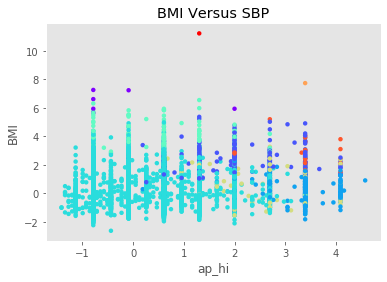

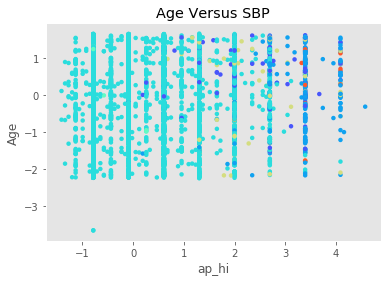

In [28]:
plt.style.use("ggplot")

%matplotlib inline

plt.scatter(X_scaled2[:, 0], X_scaled2[:, 1], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('BMI')
plt.grid()
plt.title('BMI Versus SBP')
plt.show()

plt.scatter(X_scaled2[:, 0], X_scaled2[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('Age')
plt.grid()
plt.title('Age Versus SBP')
plt.show()

# Trying with DBSCAN 

DBSCAN is a sliding-window-based algorithm that attempts to find dense areas of data points. It is a centroid-based algorithm meaning that the goal is to locate the center points of each group/class, which works by updating candidates for center points to be the mean of the points within the sliding-window. These candidate windows are then filtered in a post-processing stage to eliminate near-duplicates, forming the final set of center points and their corresponding groups.

DBSCAN poses some great advantages over other clustering algorithms. Firstly, it does not require a pe-set number of clusters at all. It also identifies outliers as noises, unlike mean-shift which simply throws them into a cluster even if the data point is very different. Additionally, it can find arbitrarily sized and arbitrarily shaped clusters quite well.

The main drawback of DBSCAN is that it doesn’t perform as well as others when the clusters are of varying density. This is because the setting of the distance threshold ε and minPoints for identifying the neighborhood points will vary from cluster to cluster when the density varies. This drawback also occurs with very high-dimensional data since again the distance threshold ε becomes challenging to estimate.


We run the DBSCAN algorithm below. The peace of code below find the best eps(distance from the center), and the mpts(minimun amount of oint in the eps area to define a cluster). The best eps is 0.15 and mpts 5. The clustering of the data is not as helpfull as the Kmean, this behavior most likely is because the eps is different for the differents cluster, and in this kind of situation the DBSCAN does not behave well.

In [29]:
%%time 

from sklearn.cluster import DBSCAN



params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X_scaled2)
        newfeature = cls_fam.labels_ # the labels from kmeans clustering

        y = y1
        X = X_scaled3
        X = np.column_stack((X,pd.get_dummies(newfeature)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 5 Average accuracy =  69.46797111487537 +- 0.8671291902516899
0.1 6 Average accuracy =  69.25196788031485 +- 0.9384197913683847
0.1 7 Average accuracy =  68.7279149964664 +- 0.8365689157653405
0.125 5 Average accuracy =  69.63194074111053 +- 0.8963714198163459
0.125 6 Average accuracy =  69.62793274046925 +- 0.9138128977449925
0.125 7 Average accuracy =  69.54793592766974 +- 0.9329590456281378
0.15 5 Average accuracy =  70.24398723903795 +- 0.8404480269861468
0.15 6 Average accuracy =  70.12796962047514 +- 0.8517436860763685
0.15 7 Average accuracy =  70.08795041407205 +- 0.8744450753875168
Wall time: 2min 20s


# Plot the DBSCAN

As pointed out before, the ploting for the DBSCAN model is not that helpful.  Therefore, we do not proceed to describe the plotting coming out of the DBSCAN model.  We decided to only describe the Kmean plot, which is described above.

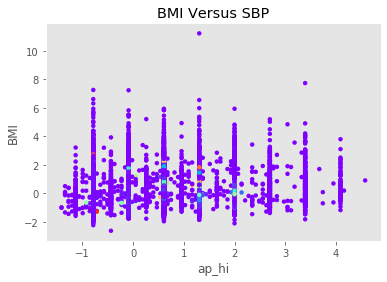

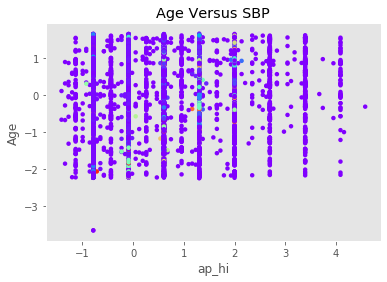

In [30]:
plt.style.use("ggplot")

%matplotlib inline

plt.scatter(X_scaled2[:, 0], X_scaled2[:, 1], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('BMI')
plt.grid()
plt.title('BMI Versus SBP')
plt.show()

plt.scatter(X_scaled2[:, 0], X_scaled2[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('Age')
plt.grid()
plt.title('Age Versus SBP')
plt.show()

# Gaussian Mixture Model

One of the major drawbacks of K-Means is its naive use of the mean value for the cluster center.

Gaussian Mixture Models (GMMs) give us more flexibility than K-Means. With GMMs we assume that the data points are Gaussian distributed; this is a less restrictive assumption than saying they are circular by using the mean. That way, we have two parameters to describe the shape of the clusters: the mean and the standard deviation! Taking an example in two dimensions, this means that the clusters can take any kind of elliptical shape (since we have a standard deviation in both the x and y directions). Thus, each Gaussian distribution is assigned to a single cluster.
To find the parameters of the Gaussian for each cluster (e.g the mean and standard deviation), we will use an optimization algorithm called Expectation–Maximization (EM).EM with 'spherical', 'diag', 'full'.

There are 2 key advantages to using GMMs. Firstly GMMs are a lot more flexible in terms of cluster covariance than K-Means; due to the standard deviation parameter, the clusters can take on any ellipse shape, rather than being restricted to circles. K-Means is actually a special case of GMM in which each cluster’s covariance along all dimensions approaches 0. Secondly, since GMMs use probabilities, they can have multiple clusters per data point. So if a data point is in the middle of two overlapping clusters, we can simply define its class by saying it belongs X-percent to class 1 and Y-percent to class 2. I.e GMMs support mixed membership.

In [31]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

X4 = np.concatenate((X_scaled1, X_scaled),axis=1) 


lowest_bic = np.infty
bic = []
n_components_range = range(7, 17)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X4)
        bic.append(gmm.bic(X4))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

# Best Gaussian Mixture Model

In [32]:
best_gmm 

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

# BIC

The Bayesian information criterion is explained in the documentation of sklearn as a comparison technique that penalizes fitted GMM models based upon the number of parameters in the models. The classical definition of the BIC is:

$BIC=\underbrace{-2\ln(l)}_{\text{better fit==more negative}}+\underbrace{k\ln(N)}_{\text{more complex==more positive}} $

where $l$ is the likelihood of the GMM model given the observations, $k$ is the number of clusters, and $N$ is the number of instances in the dataset.

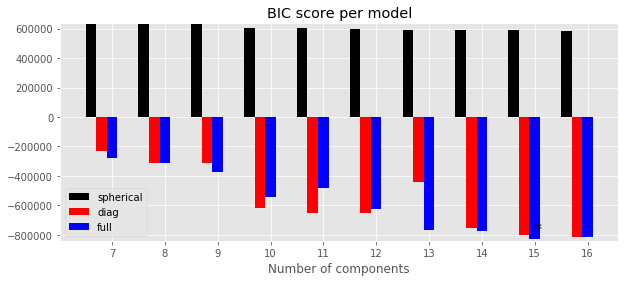

In [33]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

We found the best bic with the full expected maximazation algorithm which is depicted in the graph above.

In [34]:
X4.shape

(53053, 5)

# Analysis Gaussian

We selected the best parameters to run our Gaussian model. But the model did not behave better than the kmean algorithm.  The accuracy is 69%, lower than the 70% from the kmean, but both are very close. 

In [35]:
clf = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga')

cls = mixture.GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100, means_init=None, 
                              n_components=15, n_init=1,
                              precisions_init=None, random_state=None, reg_covar=1e-06,
                              tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                              weights_init=None)
newfeature= cls.fit_predict(X4)

y = df1['cardio']

X0 = pd.get_dummies(newfeature)
acc = cross_val_score(clf,X0,y=y,cv=cv)

print ("Average accuracy (with kmeans for BP and BMI)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for BP and BMI)=  69.63220878564196 +- 0.40032829104185075


# Plot

As pointed out before, the Gaussian model is not that helpful.  Therefore, we do not proceed to describe the plotting coming out of the Gausian model.  We decided to only describe the Kmean plot, which is described above.

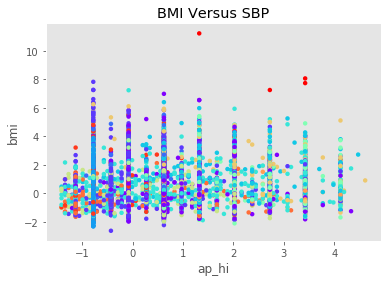

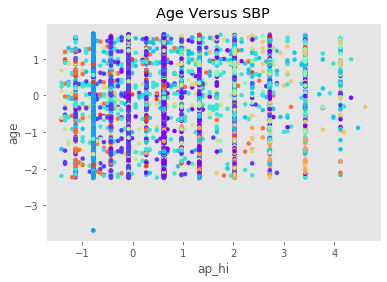

In [36]:
plt.style.use("ggplot")

%matplotlib inline
y = df1['cardio']
plt.scatter(X4[:, 0], X4[:, 1], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.grid()
plt.title('BMI Versus SBP')
plt.show()


plt.scatter(X4[:, 0], X4[:, 2], c= newfeature, 
                       cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.grid()
plt.title('Age Versus SBP')
plt.show()

# Spectral Clustering

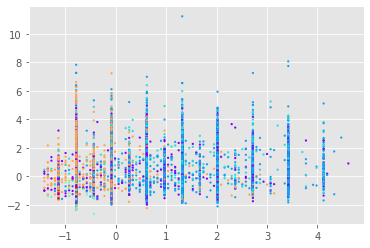

In [37]:
from sklearn.cluster import SpectralClustering

X = X4
nclust = 10

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X4)

plt.scatter(X4[:, 0], X4[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

# Conclusion and Interesting Findings

The finding that we thought was most interesting from our analysis was the cluster from our Gaussian Mixture Model which aligned with people that had cardiac disease, low-medium blood pressure, low-medium BMI, and low-medium cholesterol. This cluster is probably picking up heart risk factors that are not in the dataset, since the characteristics that the cluster showed from our data were not high-risk for heart disease.

For the purpose of predicting cardiac disease, we would use the K-Means cluster because it resulted in the highest accuracy. However, the accuracy of the model using the cluster was not higher than the accuracy of the previous model that we had created in the previous lab, so we do not plan to make use of this model.


# Cardiac Event Model Deployment

###  Usefulness of model

The model that we would want to deploy is the Gaussian Mixture Model that we created. It has 3 clusters in it and was interesting because one of the clusters--the red cluster--was made up of people who had heart disease but had only medium blood pressure and medium BMI. It is common knowledge that high blood pressure and high BMI are highly related to having heart diesaase, so the patients in the red clusters are of interest to idenitfy. It is likely that these people in the red cluster have other issues that cause them to have heart disease, so it would be useful to be able to identify them and to gather more information about them to be able to assess the cause of their heart disease and help them get treatment. 

### How model would be deployed

We could deploy this clustering tool to be used after a patient is diagnosed with heart disease. The clustering tool would categorize people into either the red cluster or the purple cluster, and this can determine what type of treatment a person would receive. If a person lands in the purple cluster, they would receive treatment for high blood pressure and high BMI. If a person lands in the red cluster they would be asked to do additional testing so the hospital could gather more information on what other factors contribute to their heart disease so they can receive more specialized treatment.

### Additional Data that would be Useful

Additional data that would be useful, would be continuous values for cholesterol metrics rather than a scale of High, Medium and Low.  It may also be useful to know if a patient is being treated for high blood pressure as perhaps the values are influenced by medication. Other variables which would be valuable are history of having coronary disease, family history of heart disease, previous heart attack, congenital heart disease (people born with heart problems), EKG abnormalities, and history of medication taking.

### Updates to Model

As additional patient data is collected, it would be helpful to update these models.  With more samples, we would be able to make better predictions.  It would not need to be updated frequently, maybe once per quarter could make our clustering more accurate and would give a more diverse sample of patients.  However, care must be taken to not cluster the data on too large of a dataset or it will take too long to process and give results.

## Exceptional Work

Our extra work consisted of a custom grid search to pick the optimum clustering methods and parameters.

In addition, below we have performed both clustering personas and personas based on non-clustered data.   We did not end up using this in our final analysis since we found optimal clusters and did not feel this really added much value or give us any brilliant insights.   However, it is shows additinal type of EDA work that could be used on this data so we didn't want to dismiss it entirely

### Cluster Personas   

In this section, we are going to dive deeper into what would make up a cluster with the continuous variables in our data.  We will focus this analysis on K-Means clustering on continuous variables since we had success in prior analyis, although we diverted to a different set of clusters for our final model.   This shows some additional data understanding methods that we used in the process.  For this type of analysis, we do not want to go over five clusters.   We already know from prior work that that Blood Pressure is the most significant indicator for cardiac heart disease in this data

We run the clustering algorithm, then divide the data by the cluster number to take an individual look at all of the patients who make up each of the clusters. 

In this analysis, some of the clusters were easy to understand.   However, we eneded up with one cluster which seemed to be a mixed bag of values in every input variable.  This is also consistent with what we saw in our analysis of graphs in our first section. There is one cluster that seems to be spread across all of the plots.


For this analysis we will also bring in our target varaible to see how many of the patients in each cluster have cardiac heart disease.   We will also group the blood pressure, age and BMI values into categories for ease of explaining our analysis.

Create age and BMI groups to use in defining what is in a cluster

In [54]:
df['age_yr'] = df['age'] /360

# create Age group categorical bins
df['ageGrp'] = np.where((df.bmi < 40), 1, 0)
df['ageGrp'] = np.where((df.bmi >= 40) & (df.bmi < 50), 2, df.bmiGrp)
df['ageGrp'] = np.where((df.bmi >= 50) & (df.bmi < 60), 3, df.bmiGrp)
df['ageGrp'] = np.where((df.bmi >= 60), 4, df.bmiGrp)

# create BMI group categorical bins
df['bmiGrp'] = np.where((df.bmi < 18.5), 1, 0)
df['bmiGrp'] = np.where((df.bmi >= 18.5) & (df.bmi < 25), 2, df.bmiGrp)
df['bmiGrp'] = np.where((df.bmi >= 25) & (df.bmi < 30), 3, df.bmiGrp)
df['bmiGrp'] = np.where((df.bmi >= 30), 4, df.bmiGrp)


Cluster the data on all the continuous variables using Kmeans. 

In [55]:
#standardize

X = df[['ap_hi', 'ap_lo', 'bmi','age_yr']].values
cardio_ind = df[["cardio"]].values
bp_level = df[["bp"]].values
bmi_level=df[["bmiGrp"]]
age_level=df[["ageGrp"]]

std_scl = StandardScaler()
scl_obj = std_scl.fit(X)

X_scaled = scl_obj.transform(X)


This clustering uses K-Means for all continous variables.  The goal here was to determine what the makeup of the patient data was.  In prior labs, we determined that blood pressure, age and bmi were significant factors to determining if a patient would have a cardiac event.   For these variables, using K-Means, we determined that the optimal number of clusers was 5.   From this, we will identify what makes the patients unique in these clusters. 

We will bring our target variable to indicate if the patient has cardiac heart disease and group the blood pressure, BMI and age variables into categories.   The blood pressure and bmi categories were described at the beginning of this document and the age was categorized into decades.


In [56]:
cls_all = KMeans(n_clusters=5, init='k-means++',random_state=1)
cls_all.fit(X_scaled)
newfeature_all = cls_all.labels_

# Create reporting data 
persona_data = np.column_stack((X_scaled,newfeature_all,cardio_ind,X, bp_level,bmi_level,age_level))
# 0=scaled ap_hi, 1= scaled ap_lo, 2=scaled BMI, 3=scaled age, 4=Cluster, 5=Cardio Indicator
# 6=AP_hi, 7=AP_lo, 8=BMI, 9-age, 10=BP, 11=BMIGRp  12=Agegrp

In [57]:
persona_data.shape

(53053, 13)

In [58]:
persona_df = pd.DataFrame({"Cluster": persona_data[:,4], "Cardio": persona_data[:,5], "ap_hi": persona_data[:,6], "ap_lo": persona_data[:,7], "BMI": persona_data[:,8], "age": persona_data[:,9], "BP": persona_data[:,10], "BMIGrp": persona_data[:,11], "Agegrp": persona_data[:,12]}) 
persona_df.head()

Cluster  Cardio  ap_hi  ap_lo        BMI        age   BP  BMIGrp  Agegrp
0      4.0     1.0  140.0   90.0  34.927679  56.188889  4.0     4.0     4.0
1      2.0     1.0  130.0   70.0  23.507805  52.380556  3.0     2.0     2.0
2      0.0     1.0  150.0  100.0  28.710479  48.952778  4.0     3.0     3.0
3      2.0     0.0  120.0   80.0  29.384676  60.872222  3.0     3.0     3.0
4      4.0     0.0  130.0   80.0  37.729725  61.425000  3.0     4.0     4.0

Plot the clusters as a whole.  Then we will analyze each cluster individually

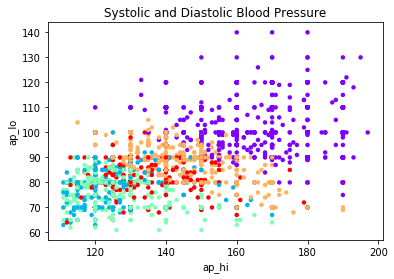

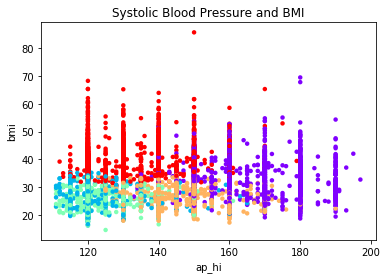

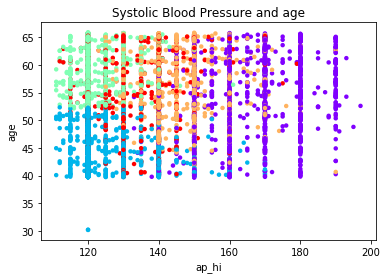

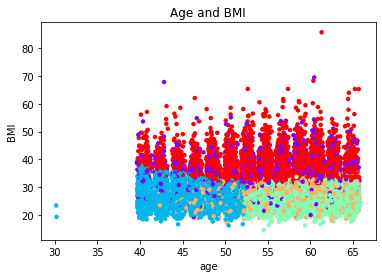

In [59]:
plt.scatter(persona_df["ap_hi"], persona_df["ap_lo"], c=persona_df["Cluster"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('ap_lo')
plt.title("Systolic and Diastolic Blood Pressure")
plt.show()
 
plt.scatter(persona_df["ap_hi"], persona_df["BMI"], c=persona_df["Cluster"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.title("Systolic Blood Pressure and BMI")
plt.show()

plt.scatter(persona_df["ap_hi"], persona_df["age"], c=persona_df["Cluster"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.title("Systolic Blood Pressure and age")
plt.show()

 
plt.scatter(persona_df["age"], persona_df["BMI"], c=persona_df["Cluster"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age'), plt.ylabel('BMI')
plt.title("Age and BMI")
plt.show()

    

### Cluster Analysis

Break up the reporting dataframe by cluster so we can analyze each cluster individually

In [60]:
clust1= persona_df[persona_df["Cluster"] == 0]
clust2= persona_df[persona_df["Cluster"] == 1]
clust3= persona_df[persona_df["Cluster"] == 2]
clust4= persona_df[persona_df["Cluster"] == 3]
clust5= persona_df[persona_df["Cluster"] == 4]
clust1.head()

Cluster  Cardio  ap_hi  ap_lo        BMI        age   BP  BMIGrp  Agegrp
2       0.0     1.0  150.0  100.0  28.710479  48.952778  4.0     3.0     3.0
36      0.0     1.0  150.0  100.0  29.410735  50.938889  4.0     3.0     3.0
37      0.0     1.0  150.0  100.0  30.846277  54.375000  4.0     4.0     4.0
43      0.0     1.0  180.0   90.0  23.795360  56.752778  4.0     2.0     2.0
44      0.0     1.0  180.0   90.0  27.548209  58.222222  4.0     3.0     3.0

##  Cluster 1 plots - Bad Heart!
### Cardiac Heart Disease, Very High Blood Pressure, Overweight and Over 50 years old

<b>Cluster 1 Profile:</b>   This cluster was well defined and 85 Percent of the patients have had a Cardiac Heart Disease.  All of the patients have Very High Blood Pressure.  They are also Overweight and most are over the age of 50.

In [61]:
print("Cardo=0", np.count_nonzero(clust1["Cardio"] == 0), "Cardio=1",np.count_nonzero(clust1["Cardio"] == 1))
print("BP=1", np.count_nonzero(clust1["BP"] == 1), "BP=2",np.count_nonzero(clust1["BP"] == 2),"BP=3",np.count_nonzero(clust1["BP"] == 3),"BP=4",np.count_nonzero(clust1["BP"] == 4))
print("BMIGrp=1", np.count_nonzero(clust1["BMIGrp"] == 1), "BMIGrp=2",np.count_nonzero(clust1["BMIGrp"] == 2),"BMIGrp=3",np.count_nonzero(clust1["BMIGrp"] == 3),"BMIGrp=4",np.count_nonzero(clust1["BMIGrp"] == 4))
print("age=under40", np.count_nonzero(clust1["Agegrp"] == 1), "age=40-50",np.count_nonzero(clust1["Agegrp"] == 2),"age=50-60",np.count_nonzero(clust1["Agegrp"] == 3),"age over60",np.count_nonzero(clust1["Agegrp"] == 4))


Cardo=0 675 Cardio=1 3943
BP=1 0 BP=2 0 BP=3 0 BP=4 4485
BMIGrp=1 0 BMIGrp=2 420 BMIGrp=3 1391 BMIGrp=4 2807
age=under40 0 age=40-50 420 age=50-60 1391 age over60 2807


###  Show Cluster 1 in Graphs

Red indicates the presence of Cardiac Heart Disease plotted against the other factors that can lead to Cardiac Heart Disease

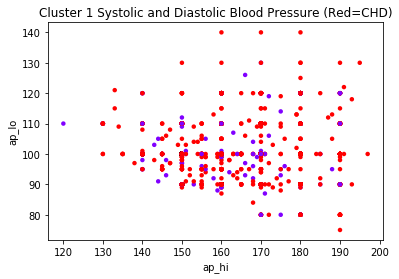

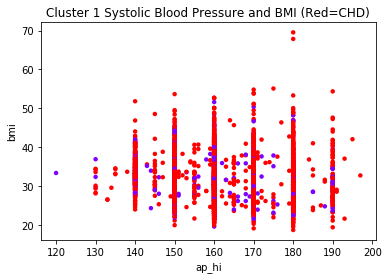

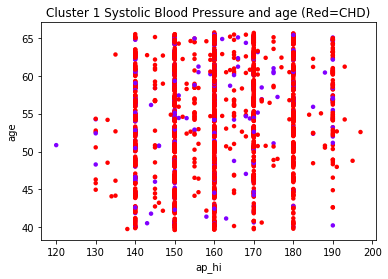

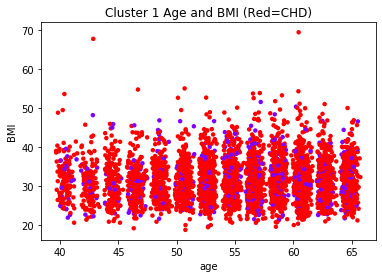

In [62]:

%matplotlib inline

plt.scatter(clust1["ap_hi"], clust1["ap_lo"], c=clust1["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('ap_lo')
plt.title("Cluster 1 Systolic and Diastolic Blood Pressure (Red=CHD)")
plt.show()
 
plt.scatter(clust1["ap_hi"], clust1["BMI"], c=clust1["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.title("Cluster 1 Systolic Blood Pressure and BMI (Red=CHD)")
plt.show()

plt.scatter(clust1["ap_hi"], clust1["age"], c=clust1["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.title("Cluster 1 Systolic Blood Pressure and age (Red=CHD)") 
plt.show()

 
plt.scatter(clust1["age"], clust1["BMI"], c=clust1["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age'), plt.ylabel('BMI')
plt.title("Cluster 1 Age and BMI (Red=CHD)")
plt.show()



## Cluster 2   Better Heart
### Less Heart Disease, High Blood Pressure, Average to Overweight BMI, Middle Aged

For this Cluster 2, 33 percent had heart disease.   Blood pressure was High, but mostly not in the highest category.  BMI indicated that they are average or over weight and they are mostly between ages of 40-60

In [63]:
print("Cardo=0", np.count_nonzero(clust2["Cardio"] == 0), "Cardio=1",np.count_nonzero(clust2["Cardio"] == 1))
print("BP=1", np.count_nonzero(clust2["BP"] == 1), "BP=2",np.count_nonzero(clust2["BP"] == 2),"BP=3",np.count_nonzero(clust2["BP"] == 3),"BP=4",np.count_nonzero(clust2["BP"] == 4))
print("BMIGrp=1", np.count_nonzero(clust2["BMIGrp"] == 1), "BMIGrp=2",np.count_nonzero(clust2["BMIGrp"] == 2),"BMIGrp=3",np.count_nonzero(clust2["BMIGrp"] == 3),"BMIGrp=4",np.count_nonzero(clust2["BMIGrp"] == 4))
print("age=under40", np.count_nonzero(clust2["Agegrp"] == 1), "age=40-50",np.count_nonzero(clust2["Agegrp"] == 2),"age=50-60",np.count_nonzero(clust2["Agegrp"] == 3),"age over60",np.count_nonzero(clust2["Agegrp"] == 4))


Cardo=0 8386 Cardio=1 4168
BP=1 84 BP=2 956 BP=3 9450 BP=4 2064
BMIGrp=1 13 BMIGrp=2 5561 BMIGrp=3 5227 BMIGrp=4 1753
age=under40 13 age=40-50 5561 age=50-60 5227 age over60 1753


###  Cluster 2 Plots

For Cluster 2, 33 percent did not have indication of Cardiac Disease, which is indicated by red.      

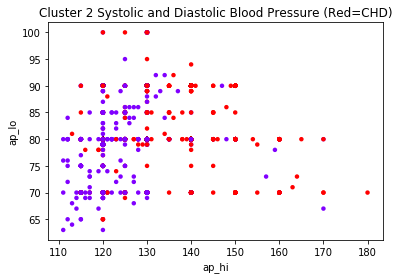

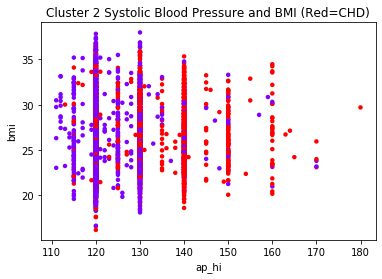

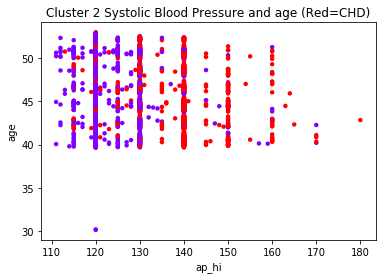

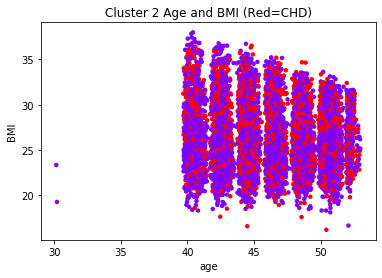

In [64]:
##  Cluster 2 plots


%matplotlib inline


plt.scatter(clust2["ap_hi"], clust2["ap_lo"], c=clust2["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('ap_lo')
plt.title("Cluster 2 Systolic and Diastolic Blood Pressure (Red=CHD)")
plt.show()
 
plt.scatter(clust2["ap_hi"], clust2["BMI"], c=clust2["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.title("Cluster 2 Systolic Blood Pressure and BMI (Red=CHD)")
plt.show()

plt.scatter(clust2["ap_hi"], clust2["age"], c=clust2["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.title("Cluster 2 Systolic Blood Pressure and age (Red=CHD)") 
plt.show()

 
plt.scatter(clust2["age"], clust2["BMI"], c=clust2["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age'), plt.ylabel('BMI')
plt.title("Cluster 2 Age and BMI (Red=CHD)")
plt.show()




## Cluster 3

### Mixture of factors

Cardio is mixed with 1 and 0.   Blood pressure is mixed, BMI is mixed age is also mixed.  This is a very inconclusive cluster

In [65]:
print("Cardo=0", np.count_nonzero(clust3["Cardio"] == 0), "Cardio=1",np.count_nonzero(clust3["Cardio"] == 1))
print("BP=1", np.count_nonzero(clust3["BP"] == 1), "BP=2",np.count_nonzero(clust3["BP"] == 2),"BP=3",np.count_nonzero(clust3["BP"] == 3),"BP=4",np.count_nonzero(clust3["BP"] == 4))
print("BMIGrp=1", np.count_nonzero(clust3["BMIGrp"] == 1), "BMIGrp=2",np.count_nonzero(clust3["BMIGrp"] == 2),"BMIGrp=3",np.count_nonzero(clust3["BMIGrp"] == 3),"BMIGrp=4",np.count_nonzero(clust3["BMIGrp"] == 4))
print("age=under40", np.count_nonzero(clust3["Agegrp"] == 1), "age=40-50",np.count_nonzero(clust3["Agegrp"] == 2),"age=50-60",np.count_nonzero(clust3["Agegrp"] == 3),"age over60",np.count_nonzero(clust3["Agegrp"] == 4))


Cardo=0 9688 Cardio=1 8416
BP=1 84 BP=2 1355 BP=3 15225 BP=4 1440
BMIGrp=1 19 BMIGrp=2 8097 BMIGrp=3 8147 BMIGrp=4 1841
age=under40 19 age=40-50 8097 age=50-60 8147 age over60 1841


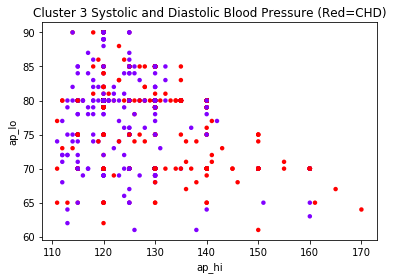

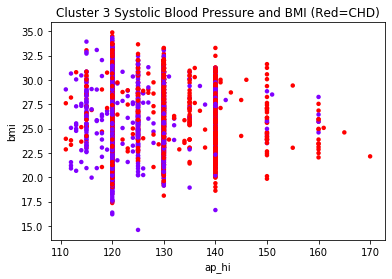

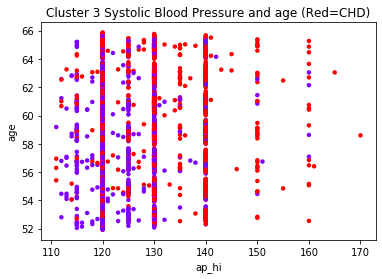

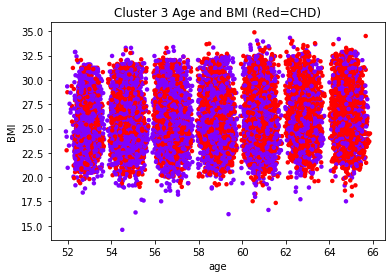

In [66]:
##  Cluster 3 plots


%matplotlib inline

plt.scatter(clust3["ap_hi"], clust3["ap_lo"], c=clust3["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('ap_lo')
plt.title("Cluster 3 Systolic and Diastolic Blood Pressure (Red=CHD)")
plt.show()
 
plt.scatter(clust3["ap_hi"], clust3["BMI"], c=clust3["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.title("Cluster 3 Systolic Blood Pressure and BMI (Red=CHD)")
plt.show()

plt.scatter(clust3["ap_hi"], clust3["age"], c=clust3["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.title("Cluster 3 Systolic Blood Pressure and age (Red=CHD)") 
plt.show()

 
plt.scatter(clust3["age"], clust3["BMI"], c=clust3["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age'), plt.ylabel('BMI')
plt.title("Cluster 3 Age and BMI (Red=CHD)")
plt.show()



## Cluster 4   Very High Blood Pressure People


### High rate of heart disease, Blood pressure high, BMI Average to Overweight, Middle Aged

These are middle aged people.  Most (79 percent) of these people have cardiac heat disease.   Blood pressure is very high, however they are not as overweight or old as cluster 1.

In [67]:
print("Cardo=0", np.count_nonzero(clust4["Cardio"] == 0), "Cardio=1",np.count_nonzero(clust4["Cardio"] == 1))
print("BP=1", np.count_nonzero(clust4["BP"] == 1), "BP=2",np.count_nonzero(clust4["BP"] == 2),"BP=3",np.count_nonzero(clust4["BP"] == 3),"BP=4",np.count_nonzero(clust4["BP"] == 4))
print("BMIGrp=1", np.count_nonzero(clust4["BMIGrp"] == 1), "BMIGrp=2",np.count_nonzero(clust4["BMIGrp"] == 2),"BMIGrp=3",np.count_nonzero(clust4["BMIGrp"] == 3),"BMIGrp=4",np.count_nonzero(clust4["BMIGrp"] == 4))
print("age=under40", np.count_nonzero(clust4["Agegrp"] == 1), "age=40-50",np.count_nonzero(clust4["Agegrp"] == 2),"age=50-60",np.count_nonzero(clust4["Agegrp"] == 3),"age over60",np.count_nonzero(clust4["Agegrp"] == 4))


Cardo=0 2224 Cardio=1 8485
BP=1 0 BP=2 0 BP=3 59 BP=4 10647
BMIGrp=1 5 BMIGrp=2 3059 BMIGrp=3 5441 BMIGrp=4 2204
age=under40 5 age=40-50 3059 age=50-60 5441 age over60 2204


79 percent of the people in category 4 have Cardiac Heart Disease as shown in Red on the plots

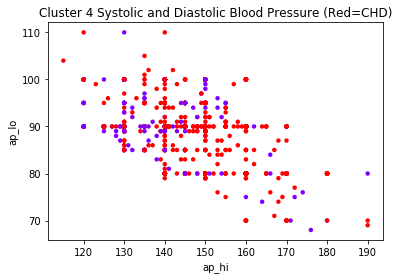

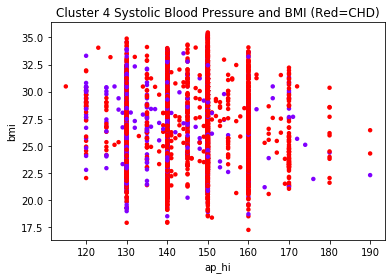

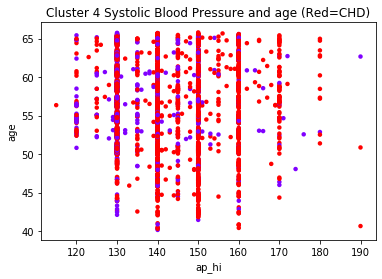

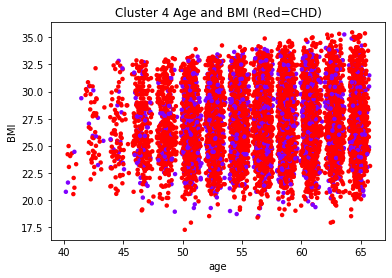

In [68]:
##  Cluster 4 plots


%matplotlib inline


plt.scatter(clust4["ap_hi"], clust4["ap_lo"], c=clust4["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('ap_lo')
plt.title("Cluster 4 Systolic and Diastolic Blood Pressure (Red=CHD)")
plt.show()
 
plt.scatter(clust4["ap_hi"], clust4["BMI"], c=clust4["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.title("Cluster 4 Systolic Blood Pressure and BMI (Red=CHD)")
plt.show()

plt.scatter(clust4["ap_hi"], clust4["age"], c=clust4["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.title("Cluster 4 Systolic Blood Pressure and age (Red=CHD)") 
plt.show()

 
plt.scatter(clust4["age"], clust4["BMI"], c=clust4["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age'), plt.ylabel('BMI')
plt.title("Cluster 4 Age and BMI (Red=CHD)")
plt.show()

## Cluster 5    Over 60 Overweight Group

###  Over 60, Very High  BMI, Blood pressure high to very high, 66 percent Heart disease

These are people over 60 years old.  66 Percent have Cardiac Heart Disease,  Blood pressure is high or very high.  They are obese.

In [69]:
print("Cardo=0", np.count_nonzero(clust5["Cardio"] == 0), "Cardio=1",np.count_nonzero(clust5["Cardio"] == 1))
print("BP=1", np.count_nonzero(clust5["BP"] == 1), "BP=2",np.count_nonzero(clust5["BP"] == 2),"BP=3",np.count_nonzero(clust5["BP"] == 3),"BP=4",np.count_nonzero(clust5["BP"] == 4))
print("BMIGrp=1", np.count_nonzero(clust5["BMIGrp"] == 1), "BMIGrp=2",np.count_nonzero(clust5["BMIGrp"] == 2),"BMIGrp=3",np.count_nonzero(clust5["BMIGrp"] == 3),"BMIGrp=4",np.count_nonzero(clust5["BMIGrp"] == 4))
print("age=under40", np.count_nonzero(clust5["Agegrp"] == 1), "age=40-50",np.count_nonzero(clust5["Agegrp"] == 2),"age=50-60",np.count_nonzero(clust5["Agegrp"] == 3),"age over60",np.count_nonzero(clust5["Agegrp"] == 4))


Cardo=0 2433 Cardio=1 4635
BP=1 9 BP=2 161 BP=3 3485 BP=4 3413
BMIGrp=1 0 BMIGrp=2 0 BMIGrp=3 0 BMIGrp=4 7068
age=under40 0 age=40-50 0 age=50-60 0 age over60 7068


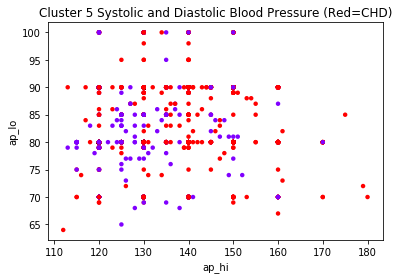

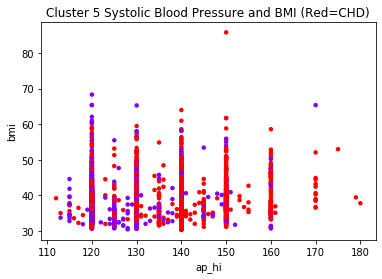

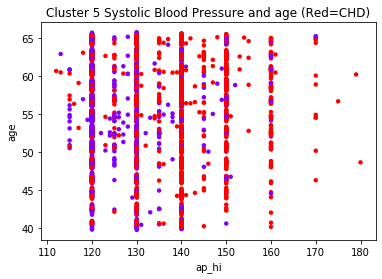

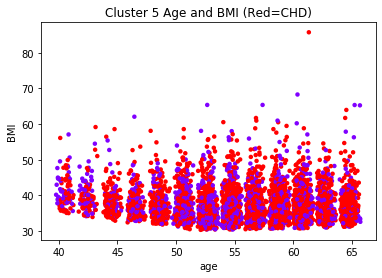

In [70]:
##  Cluster 5 plots


%matplotlib inline

plt.scatter(clust5["ap_hi"], clust5["ap_lo"], c=clust5["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('ap_lo')
plt.title("Cluster 5 Systolic and Diastolic Blood Pressure (Red=CHD)")
plt.show()
 
plt.scatter(clust5["ap_hi"], clust5["BMI"], c=clust5["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('bmi')
plt.title("Cluster 5 Systolic Blood Pressure and BMI (Red=CHD)")
plt.show()

plt.scatter(clust5["ap_hi"], clust5["age"], c=clust5["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('ap_hi'), plt.ylabel('age')
plt.title("Cluster 5 Systolic Blood Pressure and age (Red=CHD)") 
plt.show()

 
plt.scatter(clust5["age"], clust5["BMI"], c=clust5["Cardio"], cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('age'), plt.ylabel('BMI')
plt.title("Cluster 5 Age and BMI (Red=CHD)")
plt.show()

### Excel Persona Analysis:

This work was done to further understand the data without clustering.  Our goal was to really understand and categorize the patients from common knowledge rather than using a machine learning clustering algorithm.

Build the persona using two key matrix blood pressure (ap_hi) and bmi. 

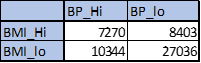

#### Building four personas:

**Hi BMI – Hi BP:** People in this category either have existing Cardio issues or at high risk of the cardio issue. We have ~7K people in this cluster.

**Hi BMI:** In this category, people will have high bmi and low BP. There are ~8K people in this bucket.

**Hi BP:** In this category, people will have BP and a low BMI. There are ~10K samples in this bucket.

**Lo BMI–Lo BP:** This is the healthiest category. In this category, people with low bmi and low blood pressure



### High Cardio Distribution (Cardio = 1)

Data was further view over laying percentage sample with Cardio issue:

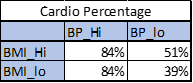

This aligns with persona. In BMI_Hi and BP_Hi bucket, 85% of samples are identified as cardio issues, and conversely, only ~39% of samples in BMI_lo and BP_lo are categorized as having the cardio issue. A higher percentage (85%) samples have cardio issues in BP_Hi bucket compared to 50% in BMI_Hi.

 
### High Cholesterol: 
Team reviewed the data in prospective of Cholesterol. 

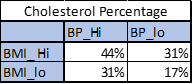

The high BP and High BMI category have 44% of the sample with high cholesterol and have 17% samples with low BP and low BMI. However, high BMI and high BP have 31% samples with high cholesterol. The best heart category had the most insufficient sample of high cholesterol and bad heart category, with the highest number of high cholesterol samples. 

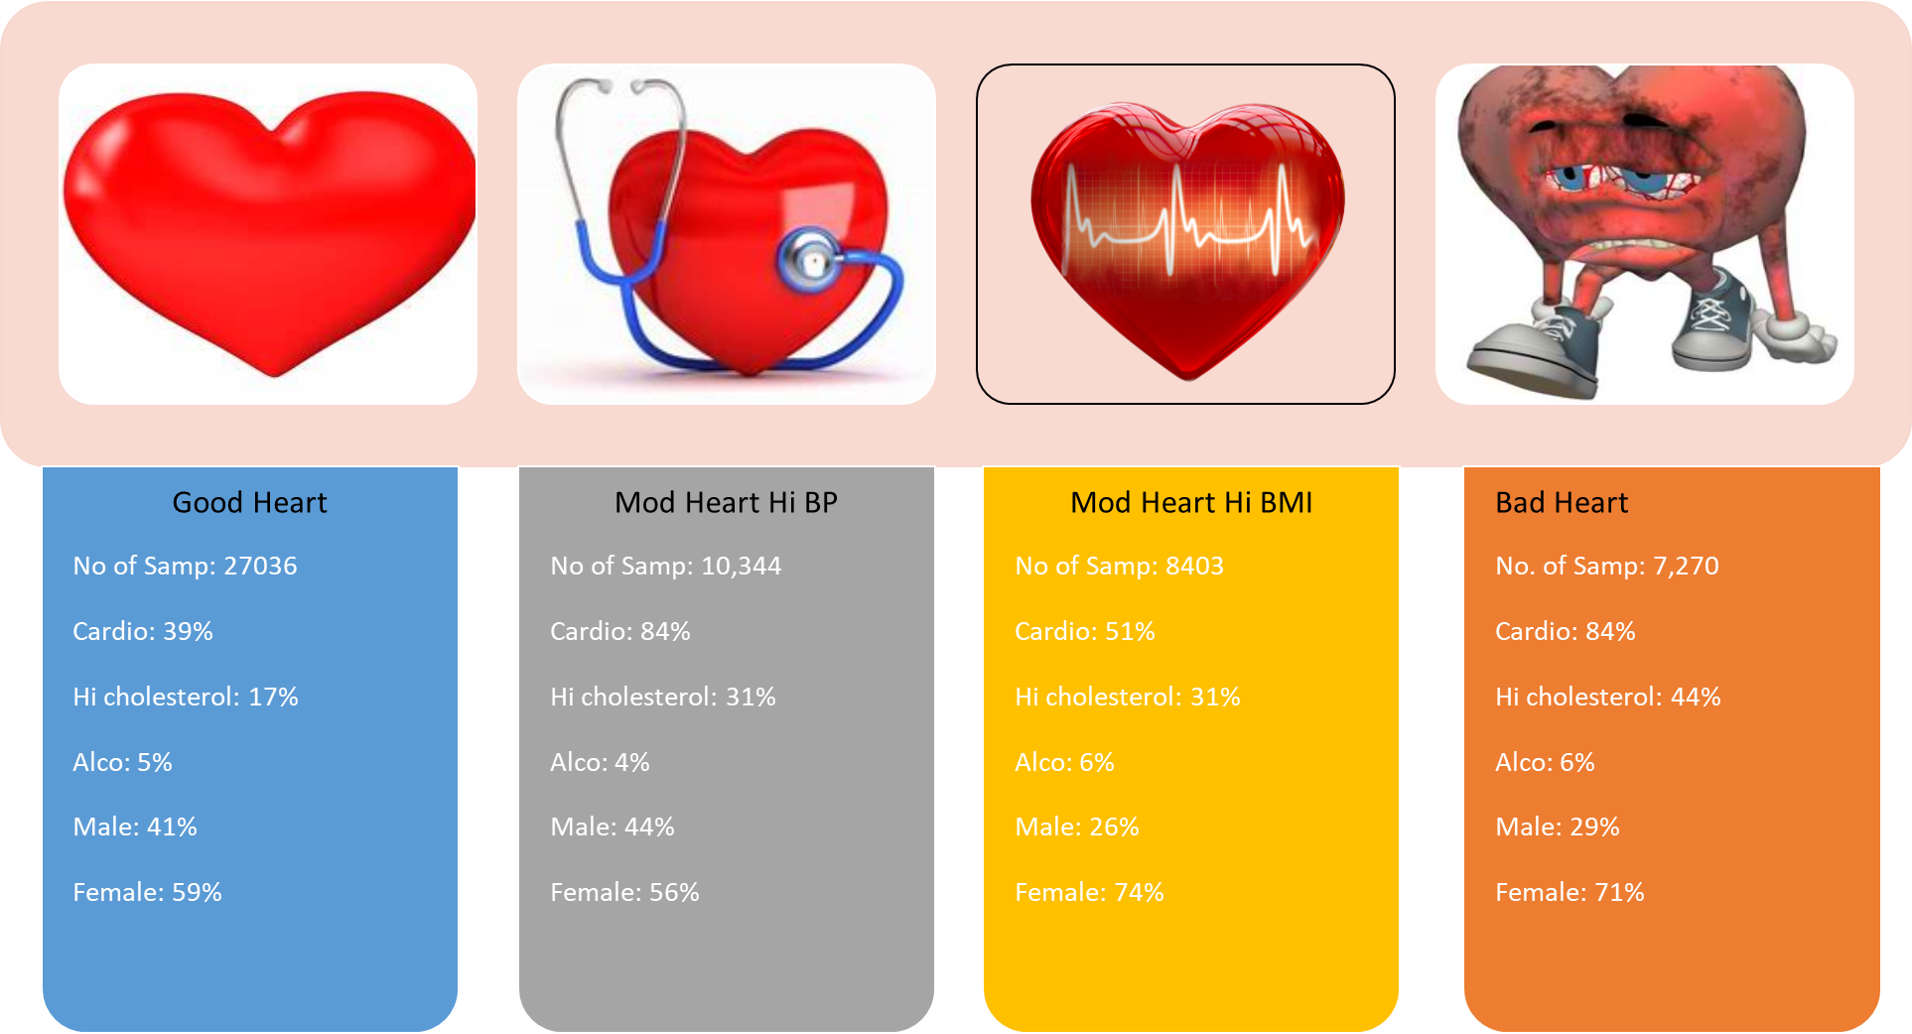